This code generates a bunch of mixed sinosodal laser profiles, of same magnitude and mean. For testing only.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import aesara.tensor as tt
import pandas as pd
from scipy.stats import qmc
from scipy.interpolate import UnivariateSpline
from scipy import signal

# ipympl required for widget otherwise comment out
#%matplotlib widget
#warnings.simplefilter(action="ignore", category=FutureWarning)

We create the LHS sampling plan for laser profile features

[Text(0.5, 0, 'Mean Laser Power (W)'),
 Text(0.5, 0.5, 'Laser Power Variance (W)'),
 Text(0.5, 0, 'Filtered Frequency (Hz)')]

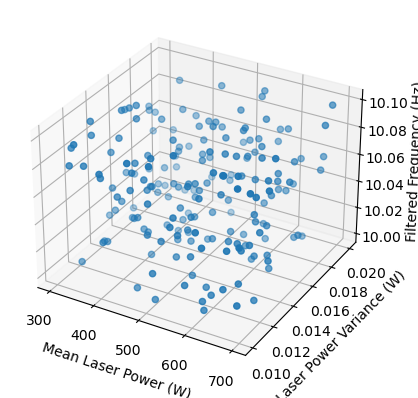

In [9]:
number_samples = 200
random_seed = 12

l_bounds = [10, 300, 0.01, 0]  ## lower bound of Frequency of Laser Power, Mean Laser Power, Variance of Laser Power, and Amplitude of step
u_bounds = [10.1, 700, 0.02, 1] ## upper bound of Frequency of Laser Power, Mean Laser Power, Variance of Laser Power, and Amplitude of step

#--------------------------------------------------------------------------------------------------------------------------------------
# Create latin hypercube sampling
sampler = qmc.LatinHypercube(d=4, seed=random_seed)
sample = sampler.random(n=number_samples)

# Rescale LHC to parameters
sampling_plan = qmc.scale(sample, l_bounds, u_bounds)

# separate into components
mean_power_value = sampling_plan[:,1]
Variance_laser_power_value = sampling_plan[:, 2]
Frequency_value = sampling_plan[:,0]
Amplitude_of_step = sampling_plan[:,3]

lhc_fig = plt.figure()
lhc_ax = lhc_fig.add_subplot(projection='3d')
lhc_ax.scatter3D(mean_power_value, Variance_laser_power_value, Frequency_value)
lhc_ax.set(xlabel="Mean Laser Power (W)", ylabel="Laser Power Variance (W)", zlabel="Filtered Frequency (Hz)")

Sequential sampling (1 chains in 1 job)
Metropolis: [mu]
Sampling 1 chain for 1_000 tune and 157_501 draw iterations (1_000 + 157_501 draws total) took 14 seconds.
Sequential sampling (1 chains in 1 job)
Metropolis: [mu]
Sampling 1 chain for 1_000 tune and 157_501 draw iterations (1_000 + 157_501 draws total) took 14 seconds.
Sequential sampling (1 chains in 1 job)
Metropolis: [mu]
Sampling 1 chain for 1_000 tune and 157_501 draw iterations (1_000 + 157_501 draws total) took 14 seconds.
Sequential sampling (1 chains in 1 job)
Metropolis: [mu]
Sampling 1 chain for 1_000 tune and 157_501 draw iterations (1_000 + 157_501 draws total) took 14 seconds.
Sequential sampling (1 chains in 1 job)
Metropolis: [mu]
Sampling 1 chain for 1_000 tune and 157_501 draw iterations (1_000 + 157_501 draws total) took 14 seconds.
Sequential sampling (1 chains in 1 job)
Metropolis: [mu]
Sampling 1 chain for 1_000 tune and 157_501 draw iterations (1_000 + 157_501 draws total) took 14 seconds.
Sequential sampl

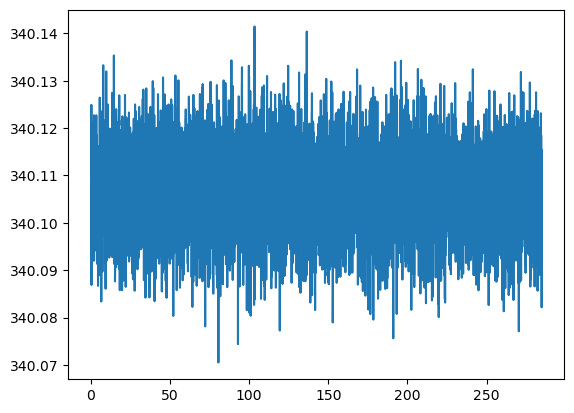

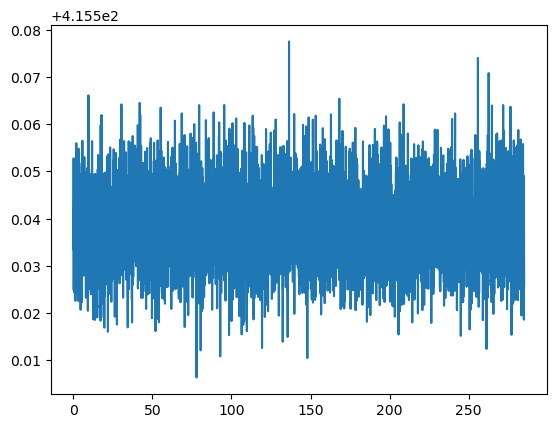

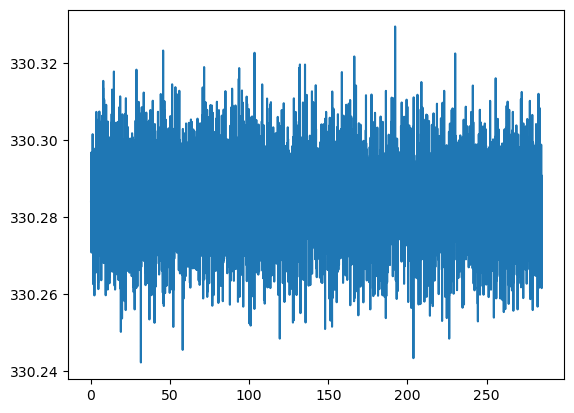

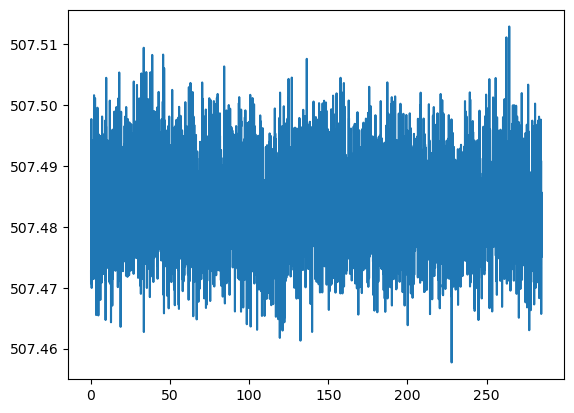

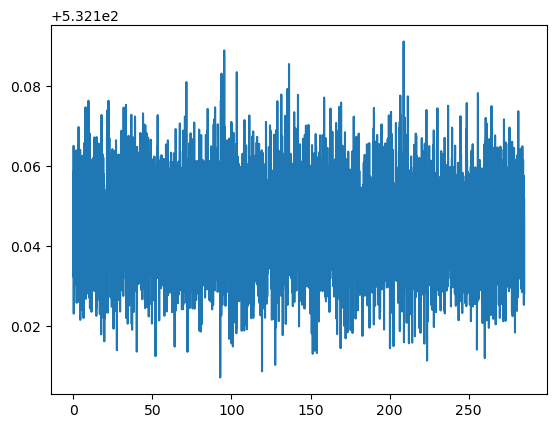

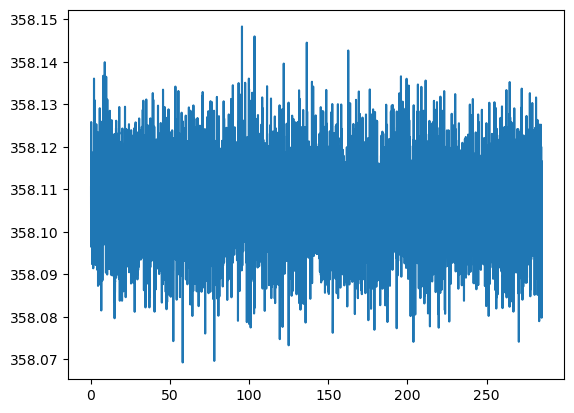

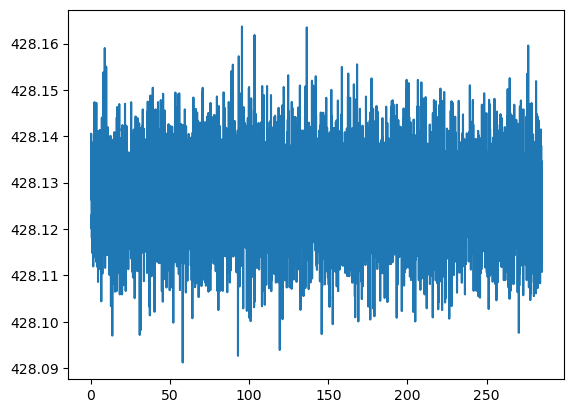

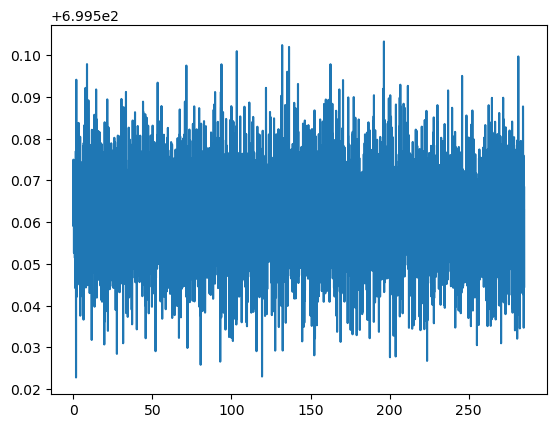

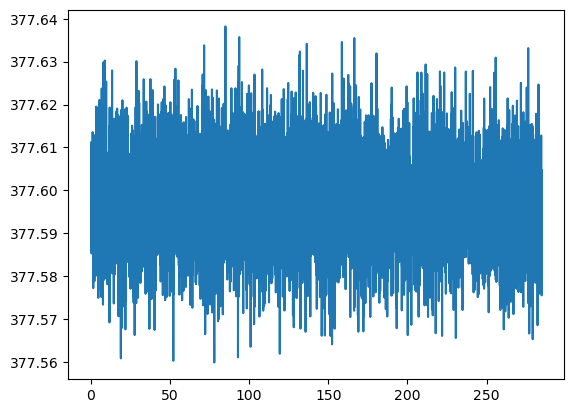

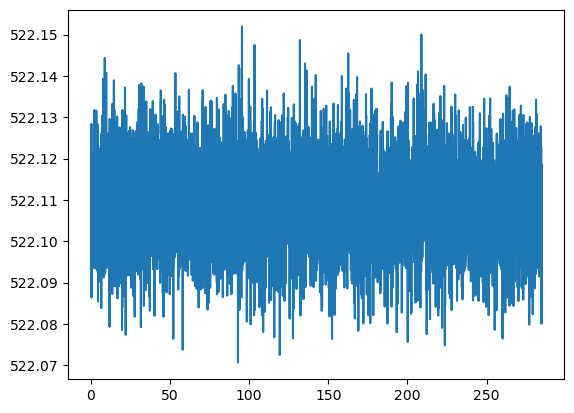

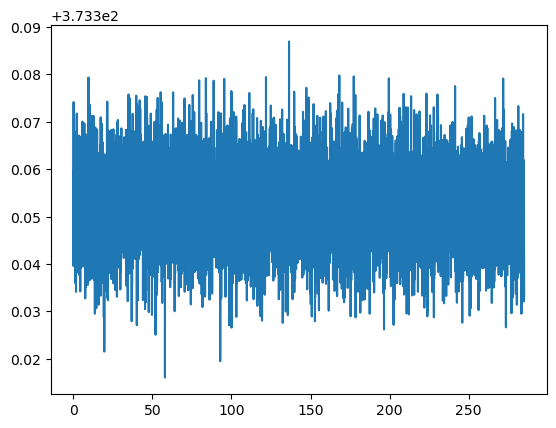

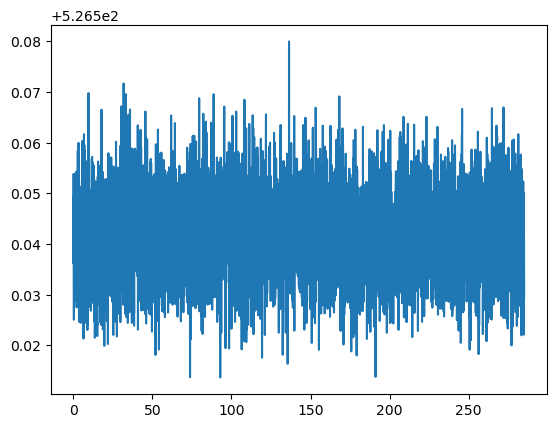

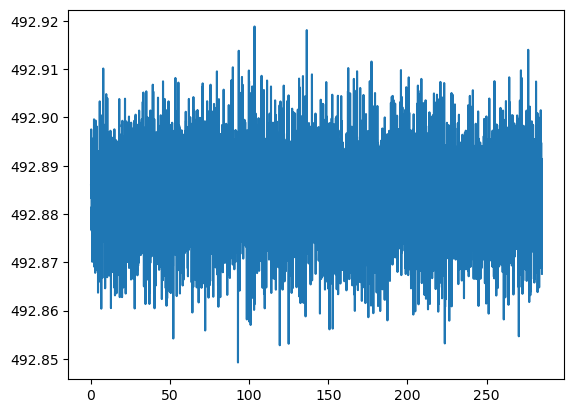

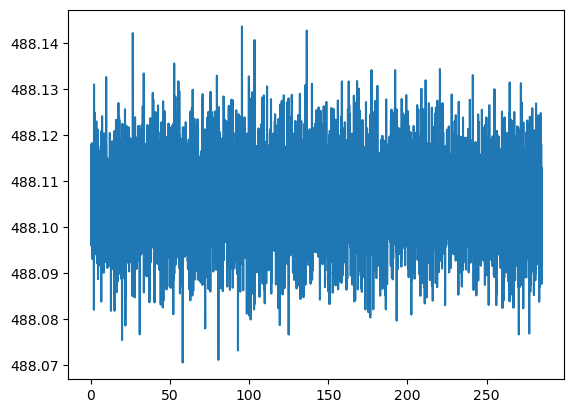

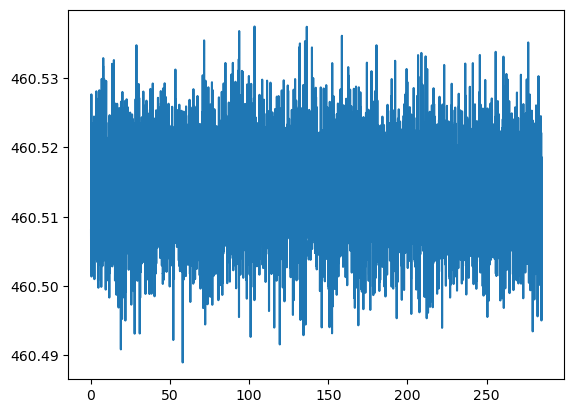

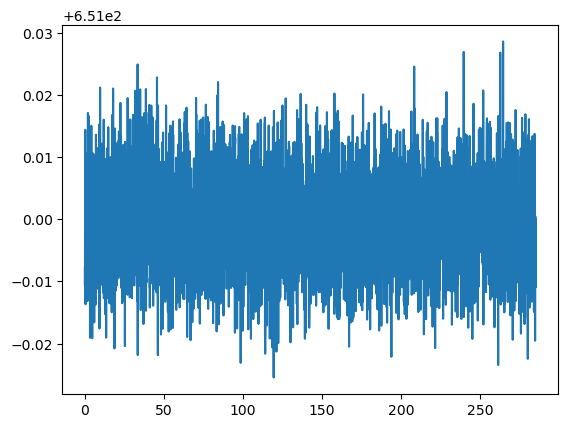

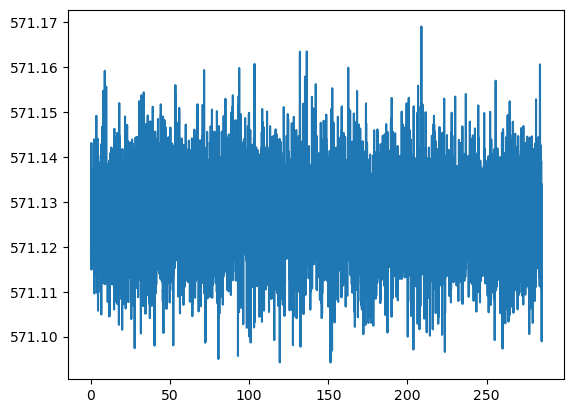

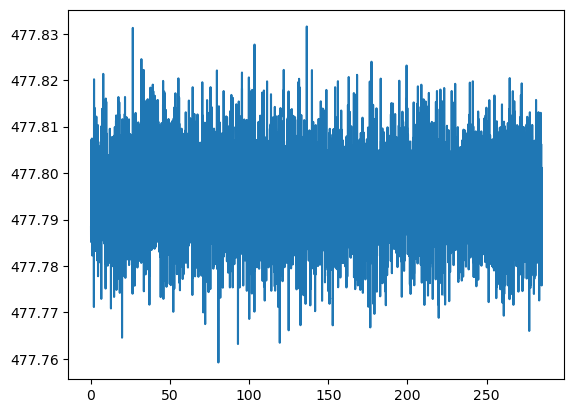

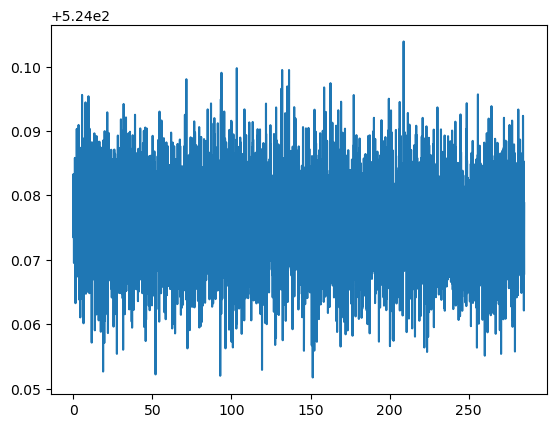

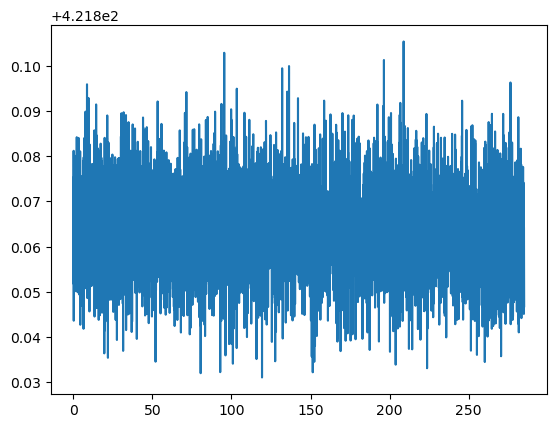

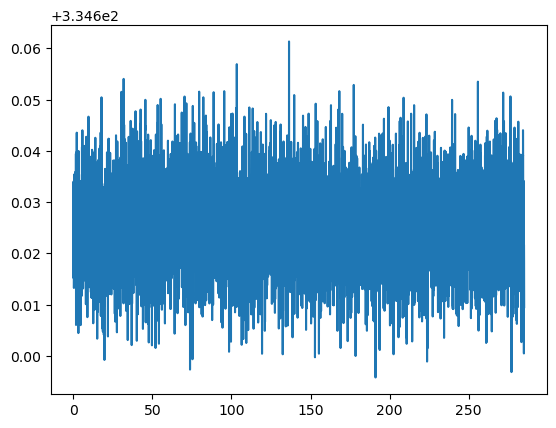

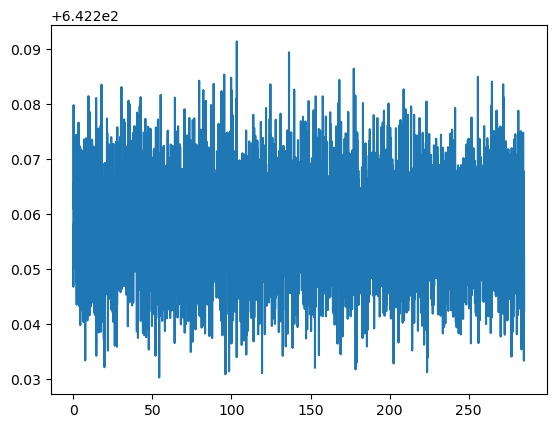

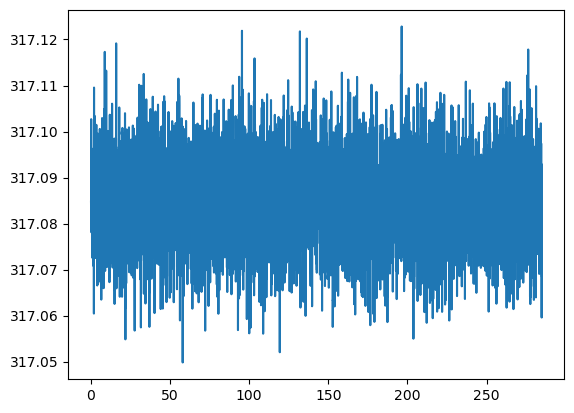

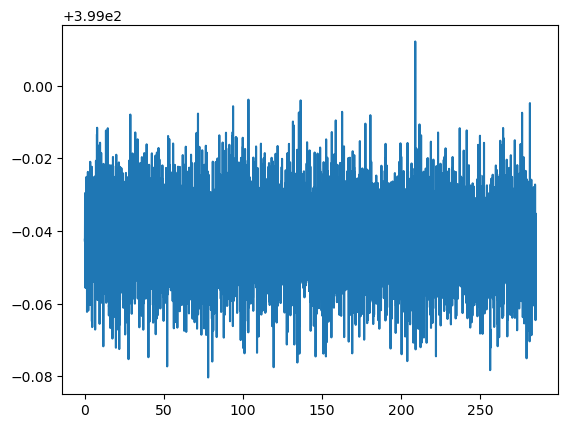

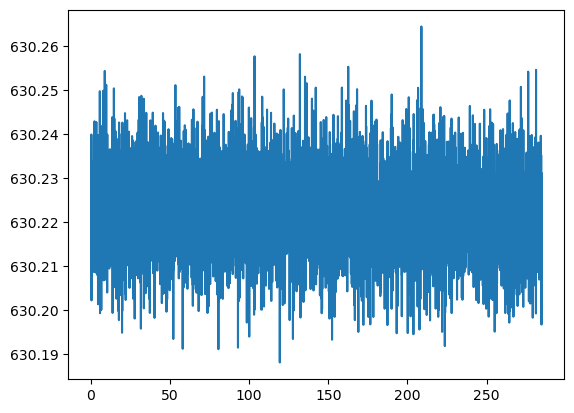

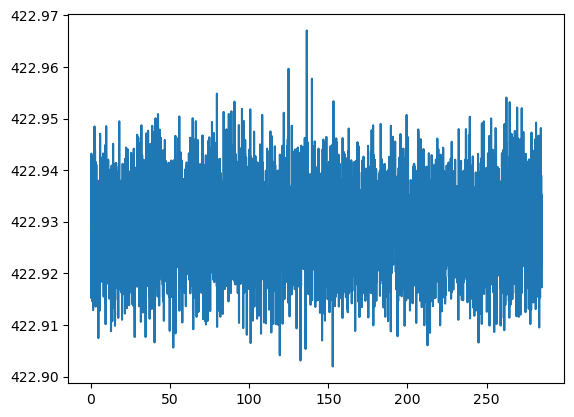

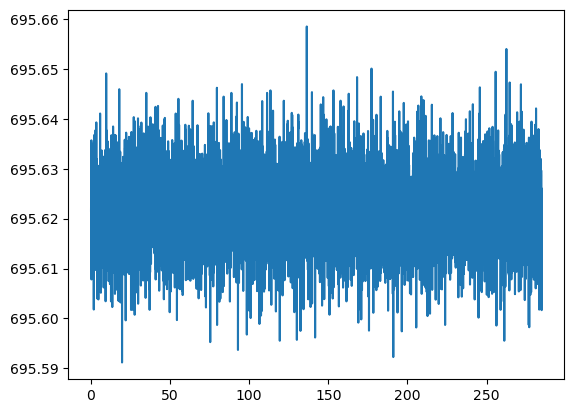

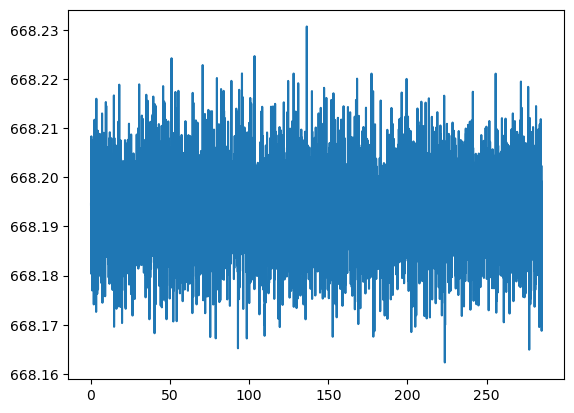

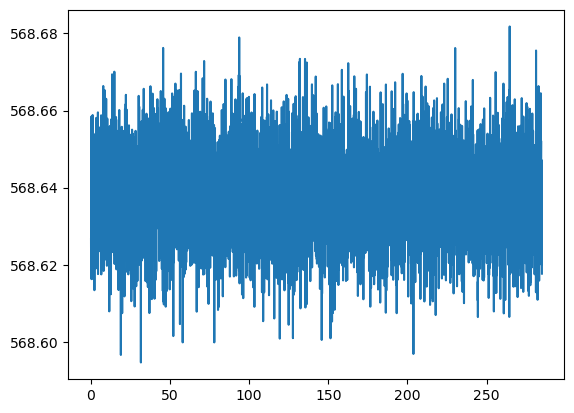

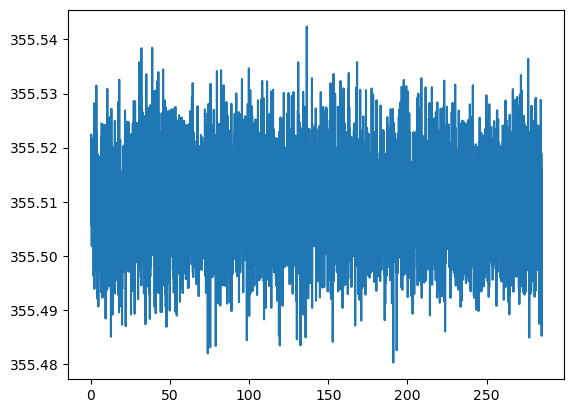

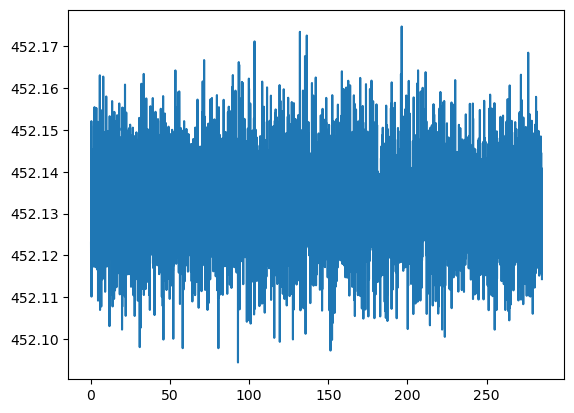

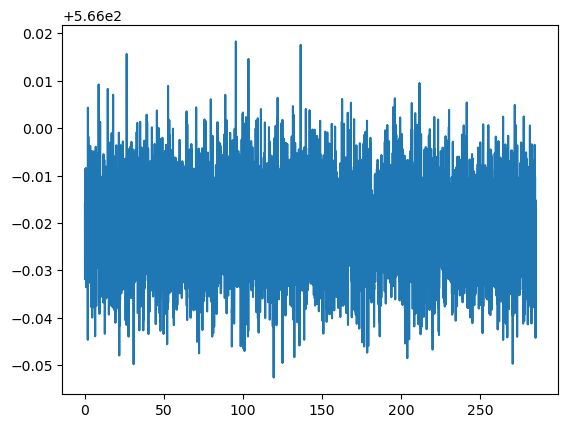

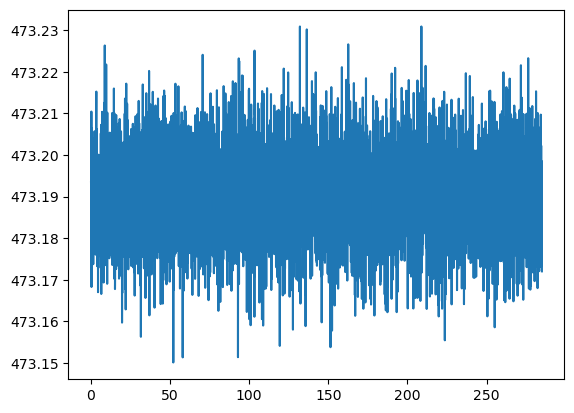

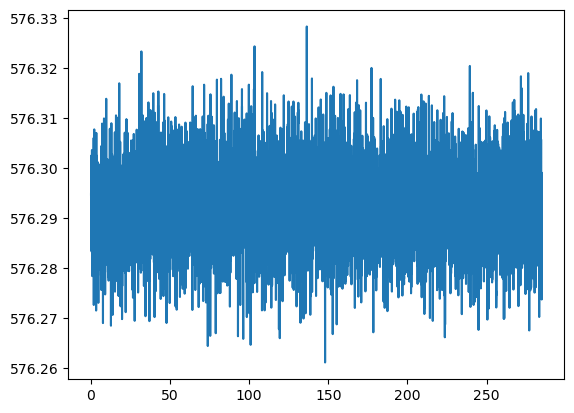

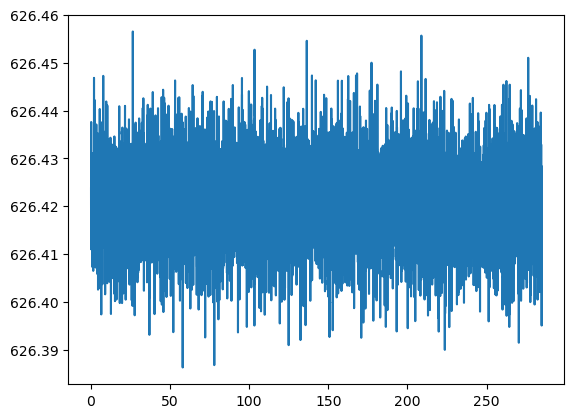

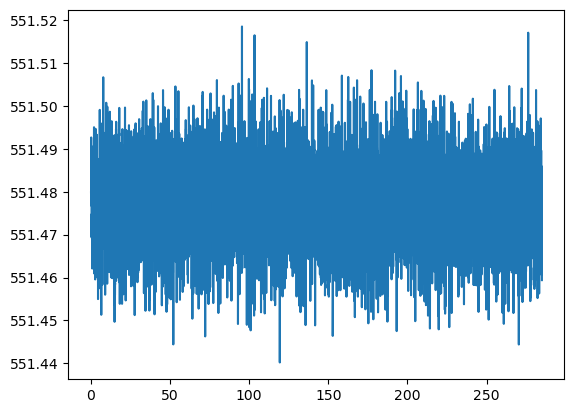

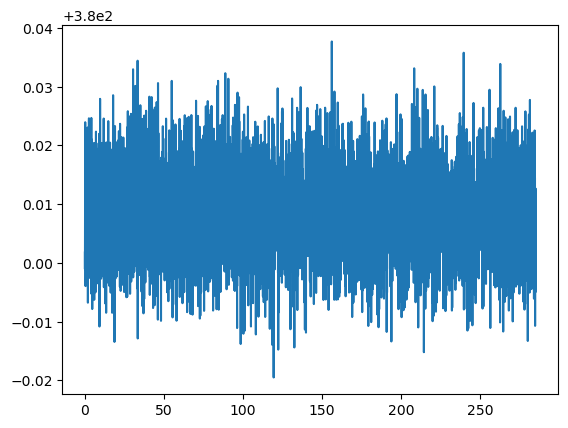

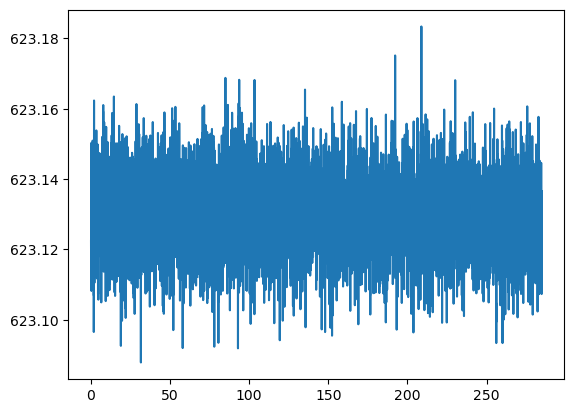

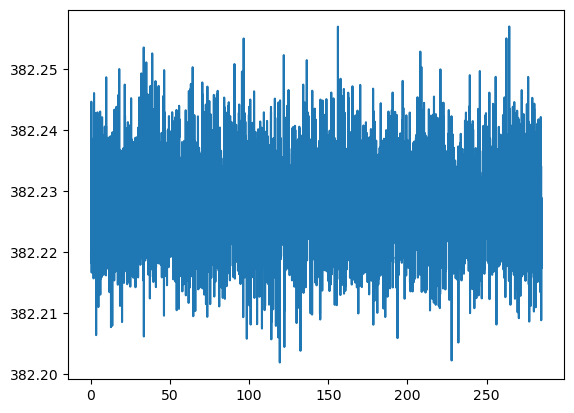

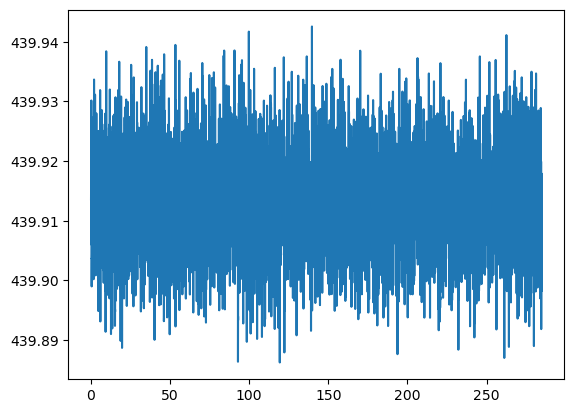

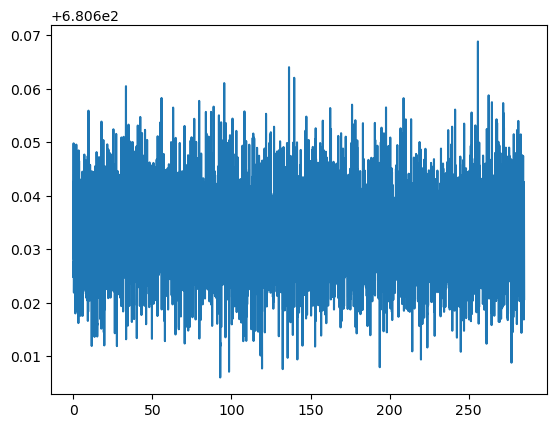

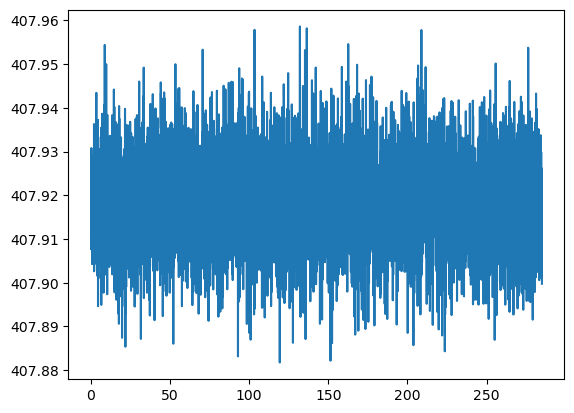

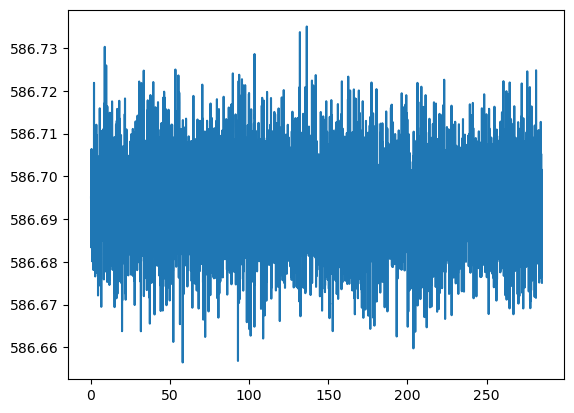

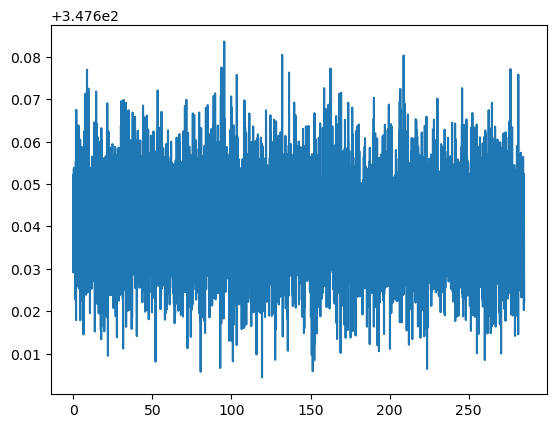

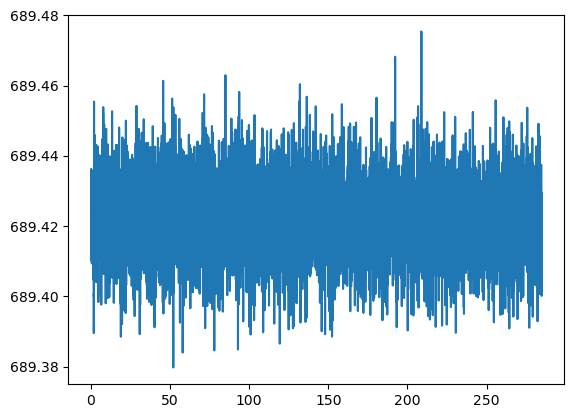

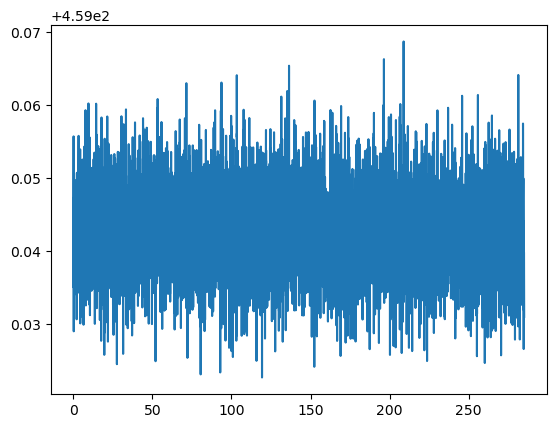

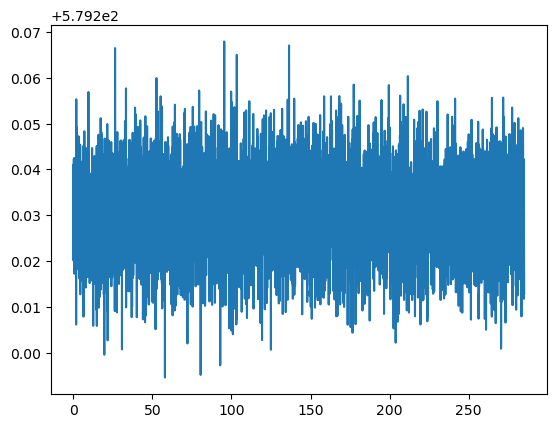

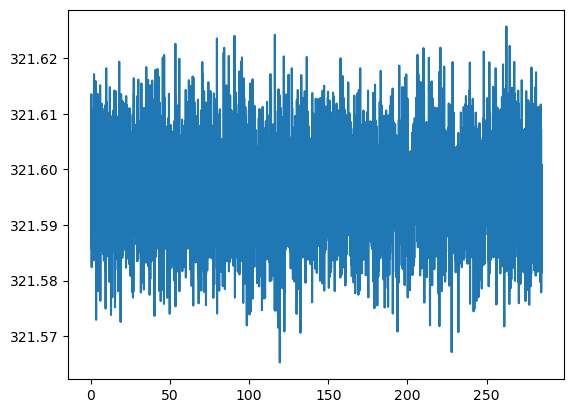

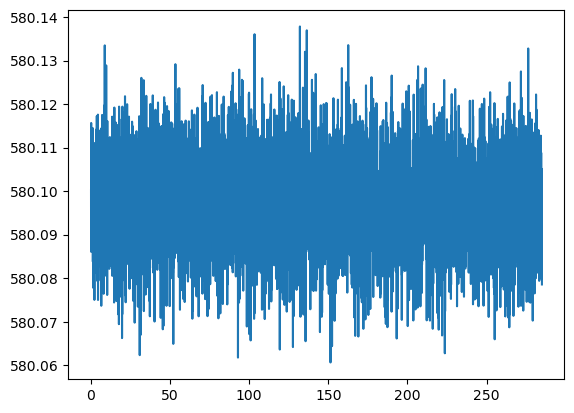

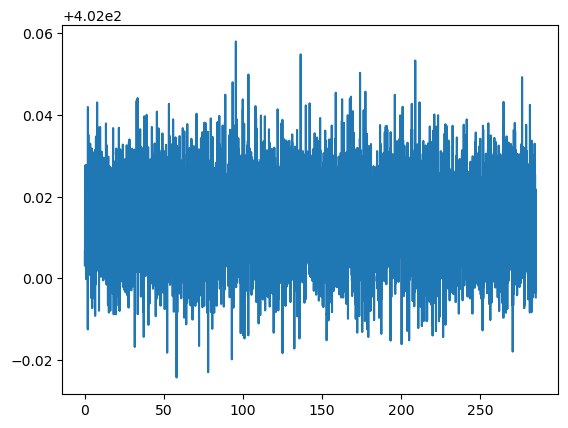

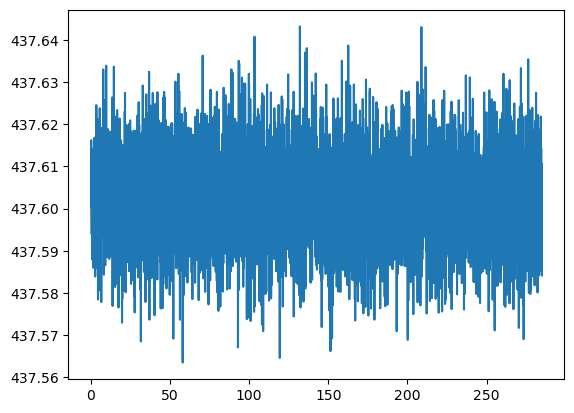

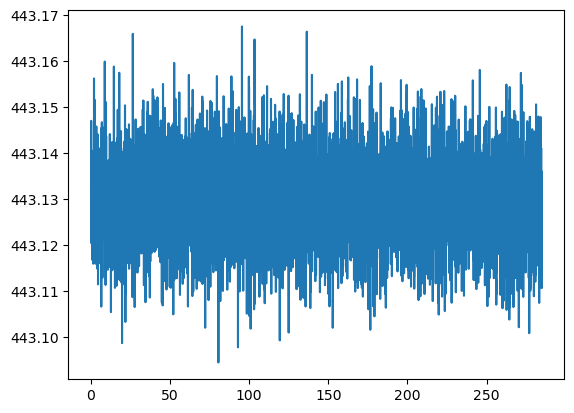

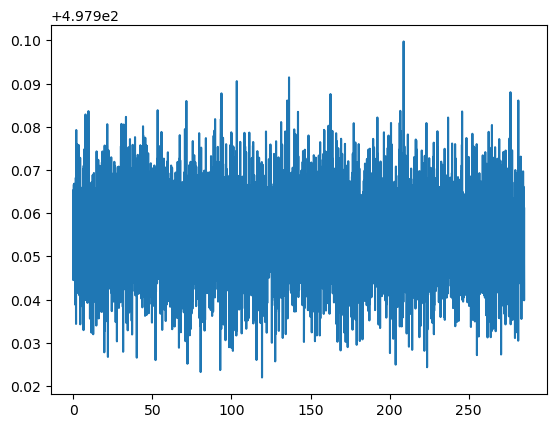

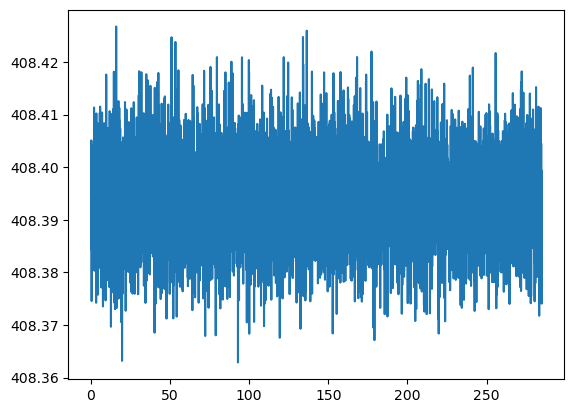

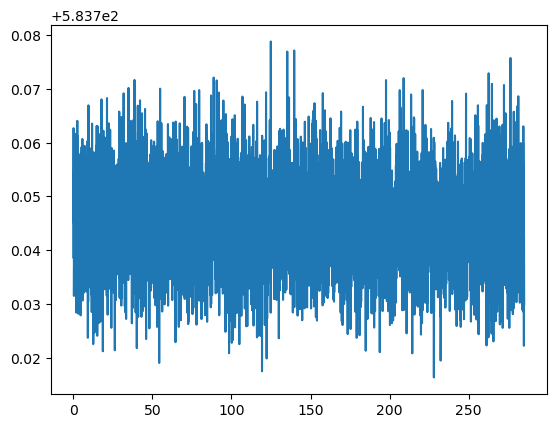

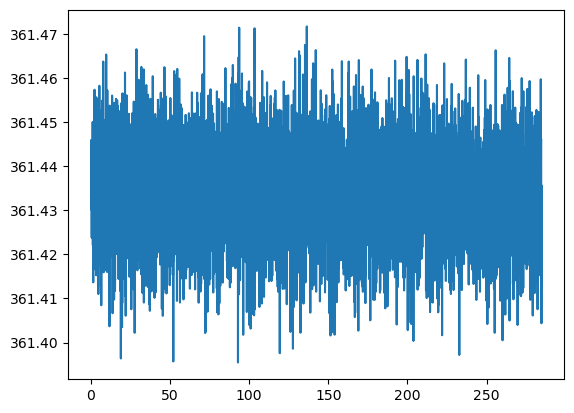

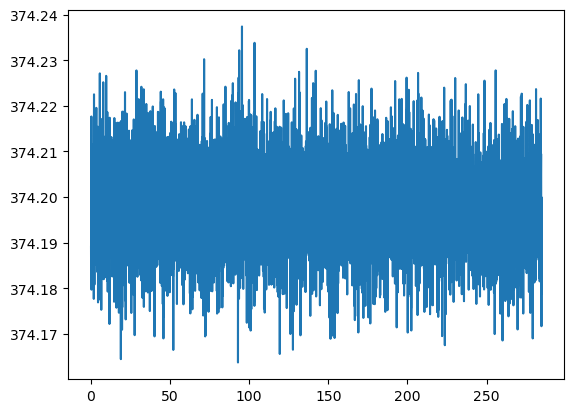

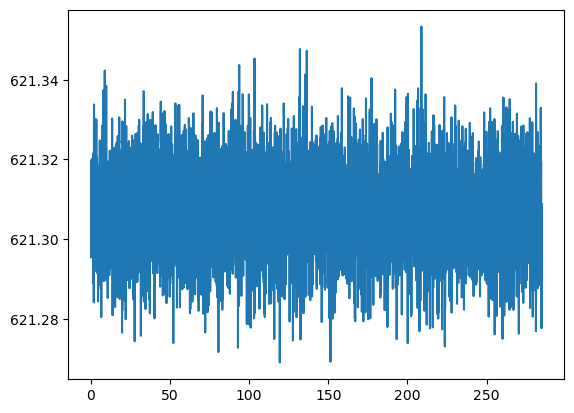

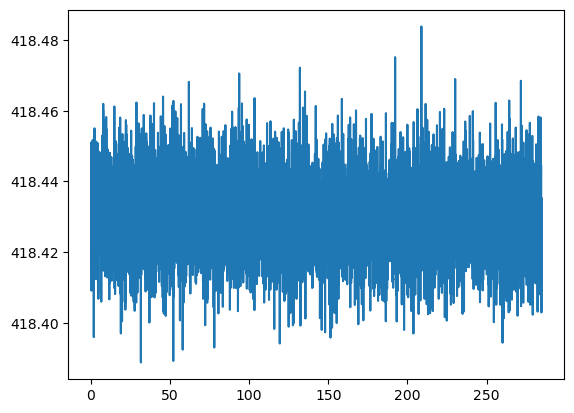

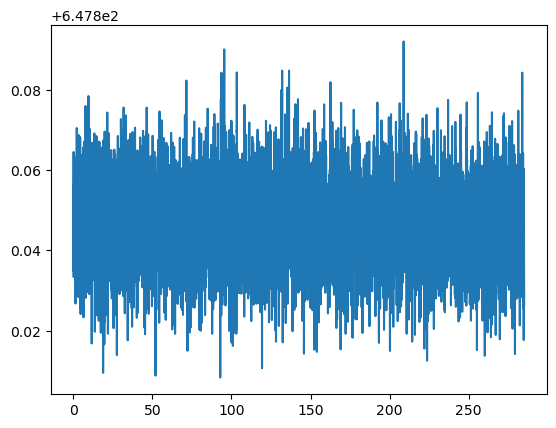

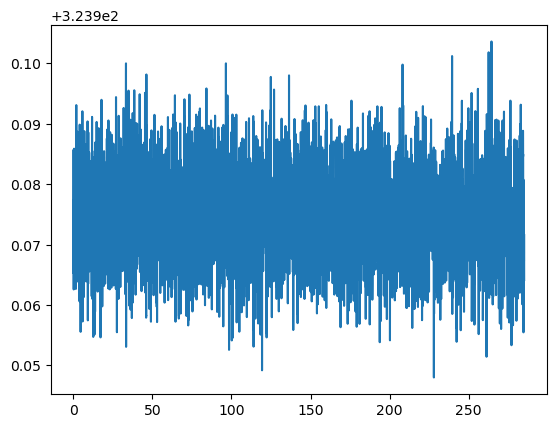

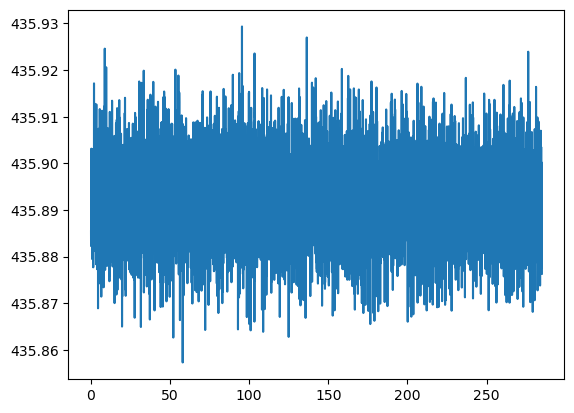

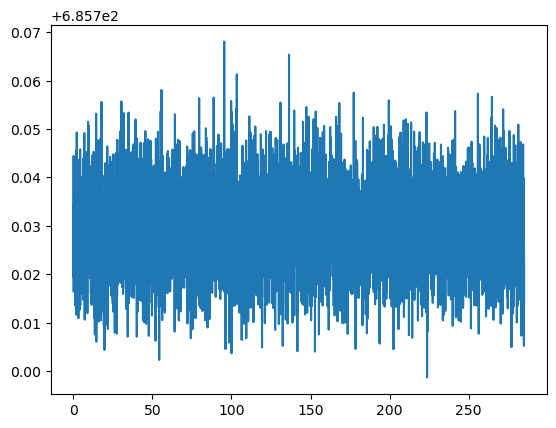

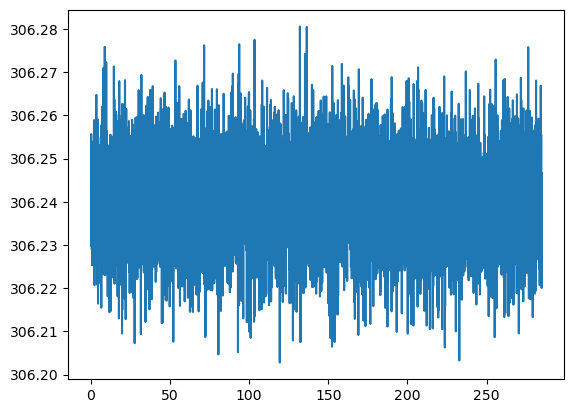

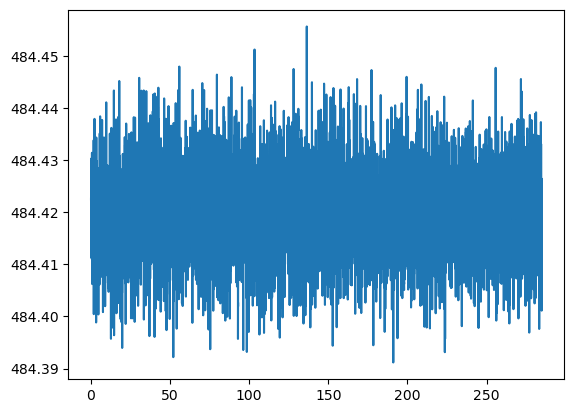

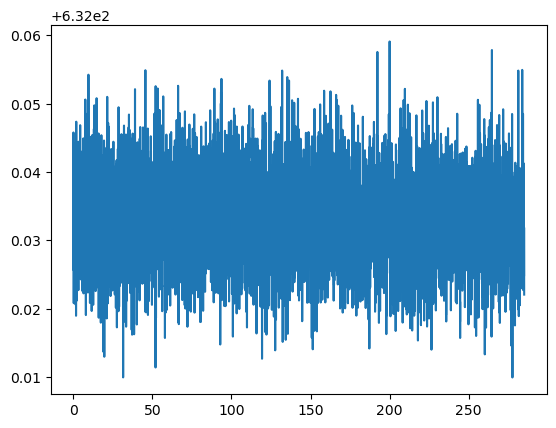

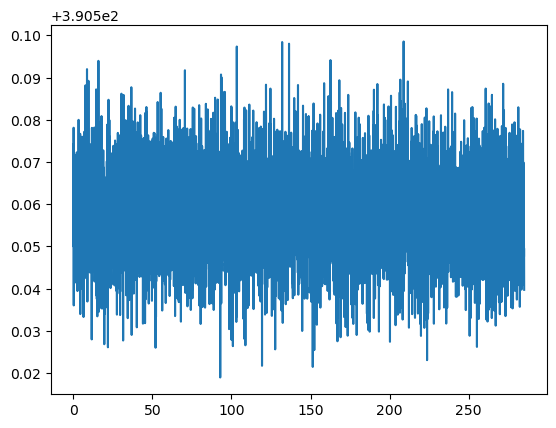

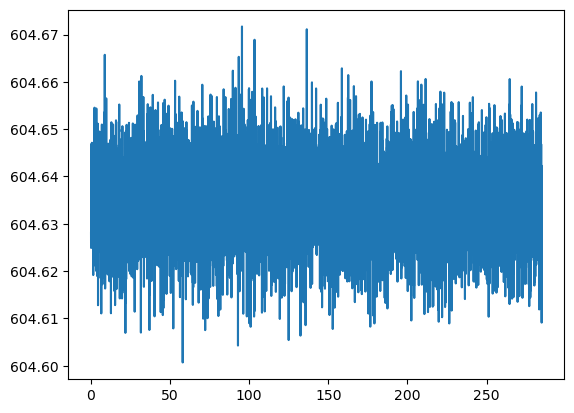

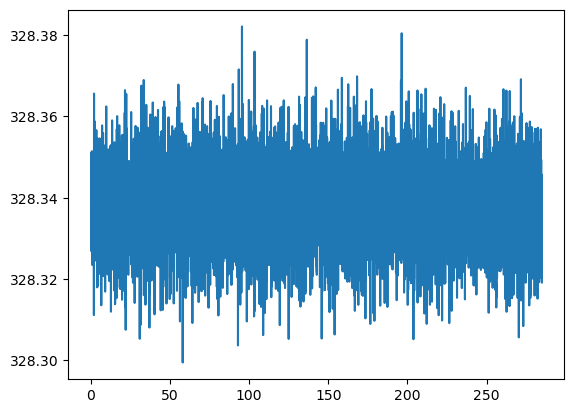

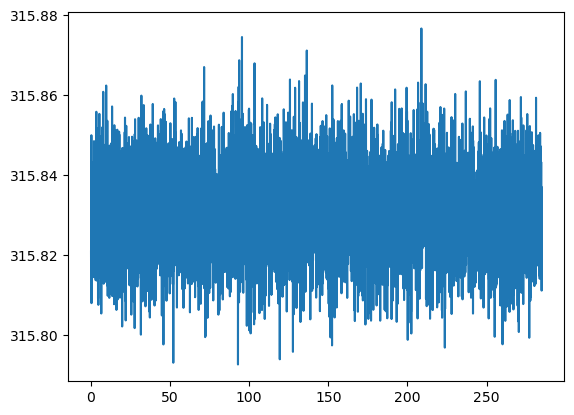

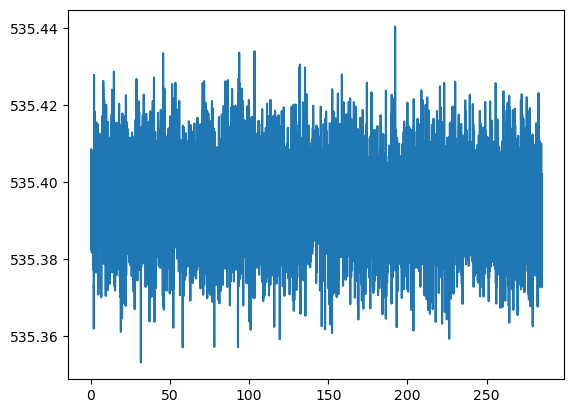

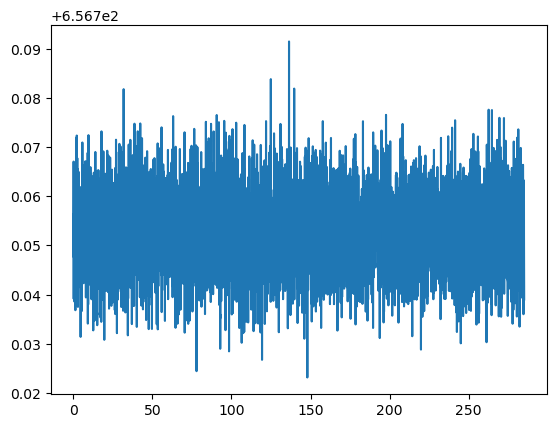

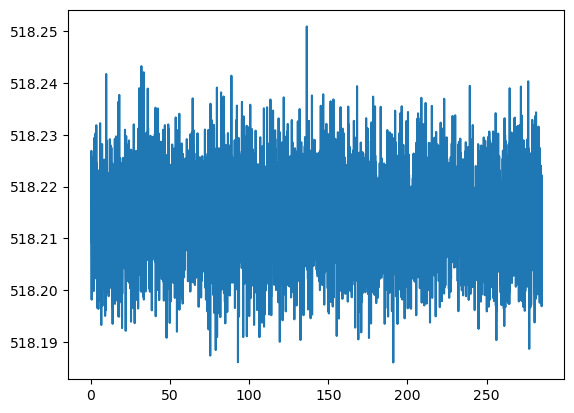

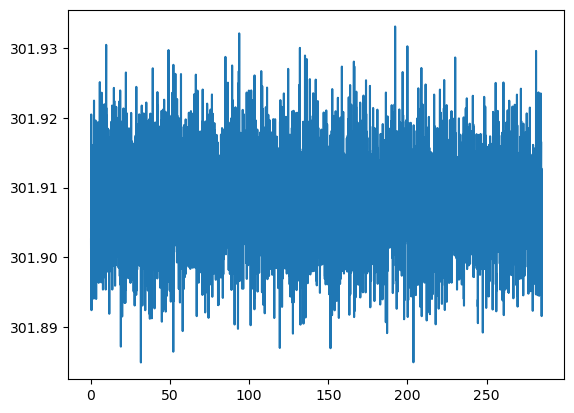

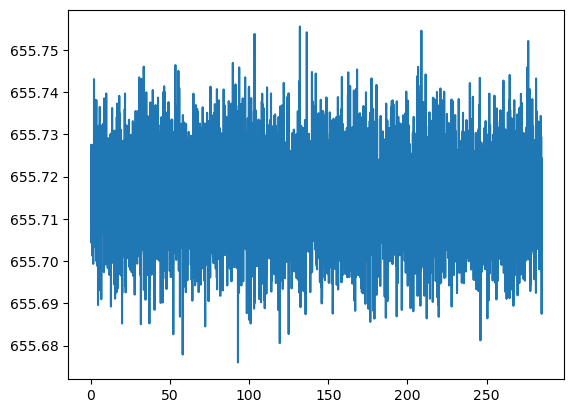

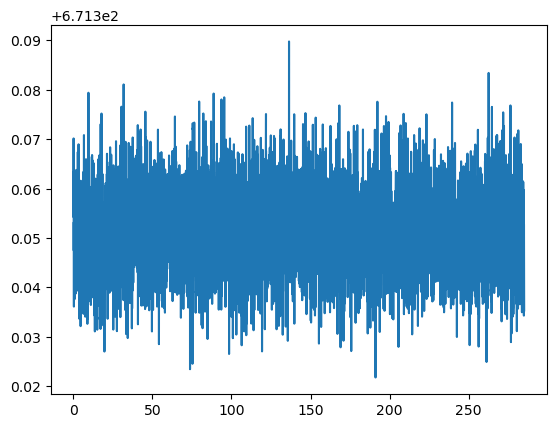

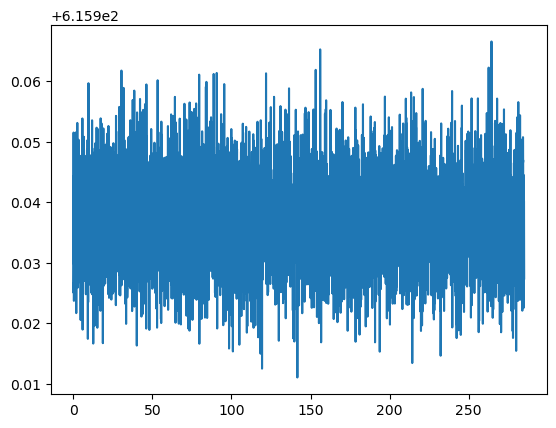

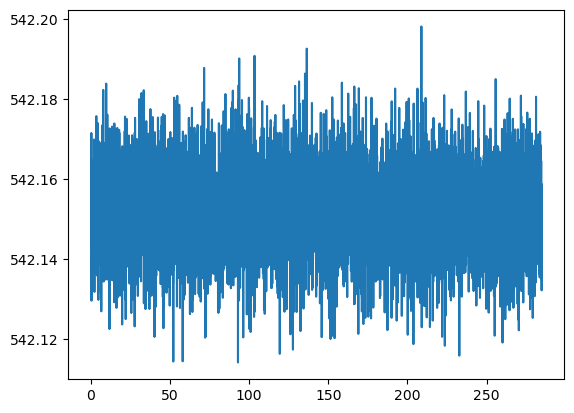

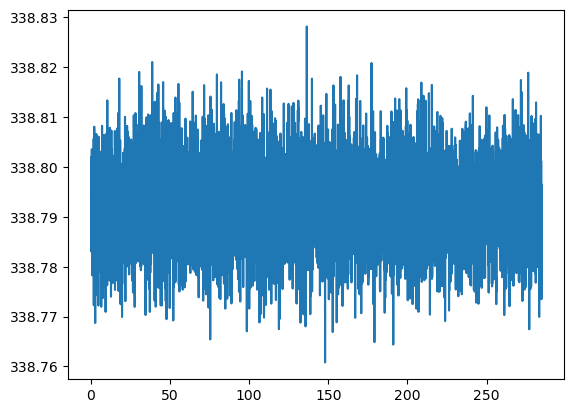

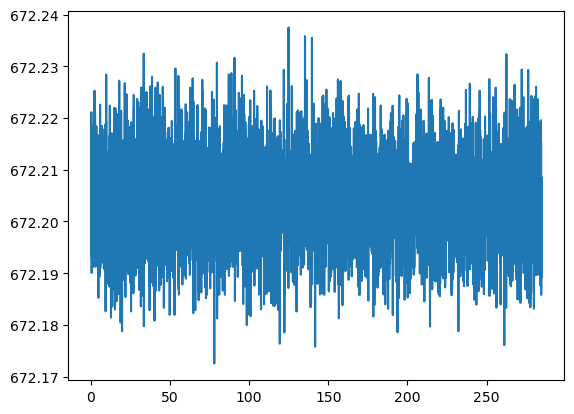

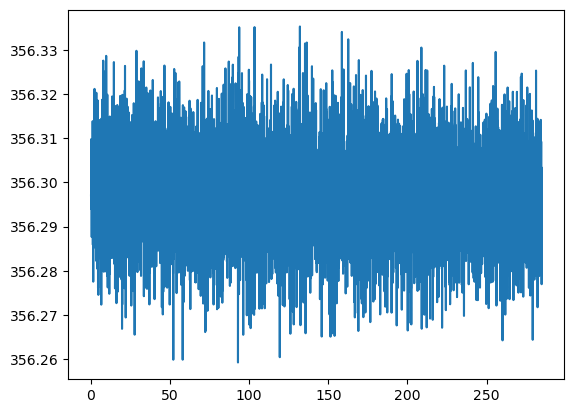

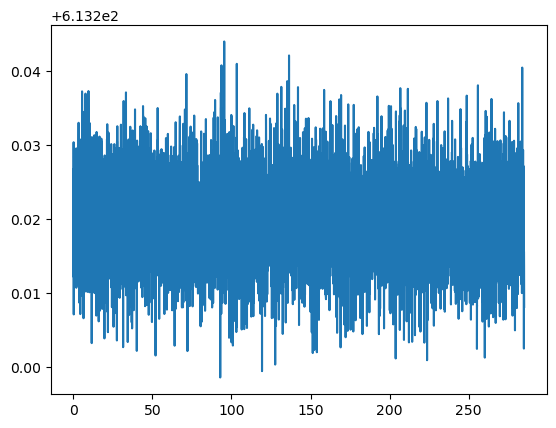

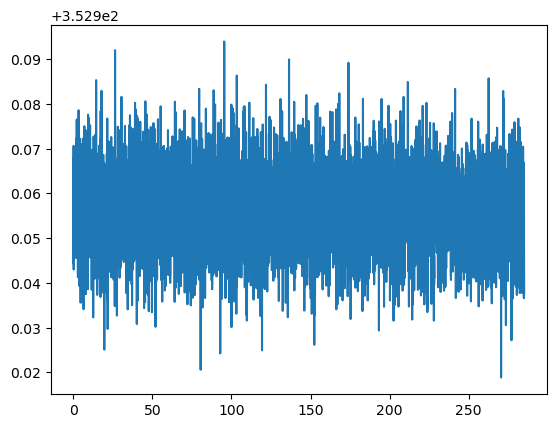

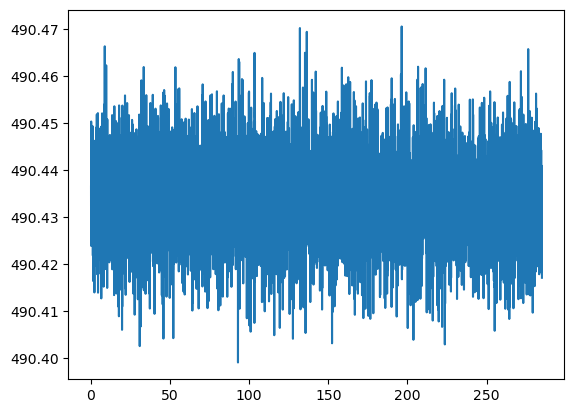

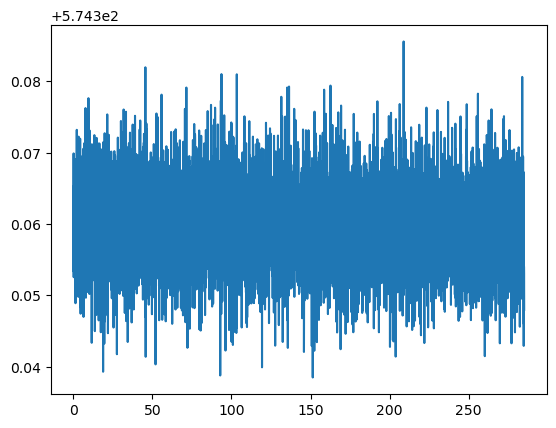

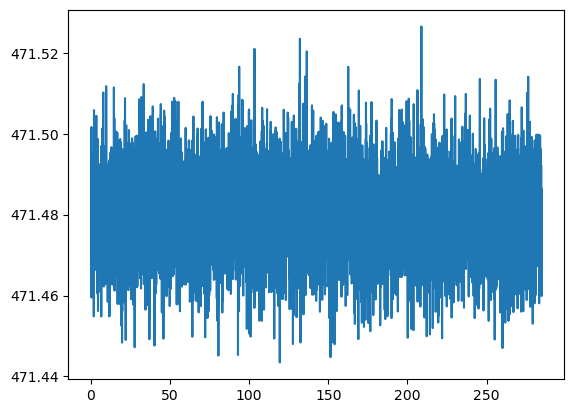

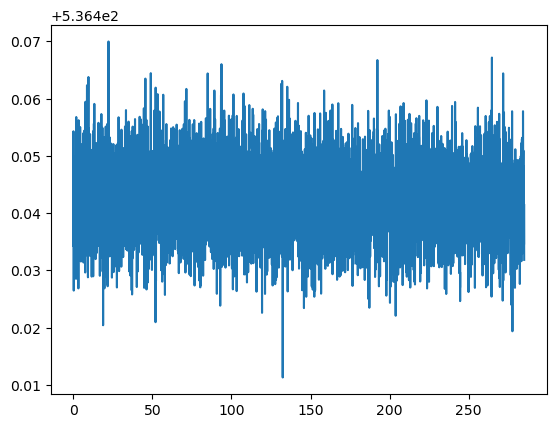

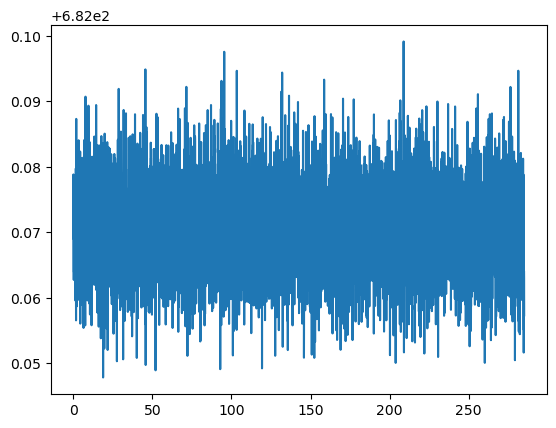

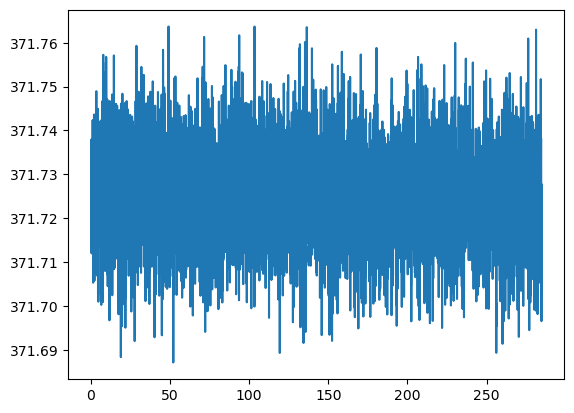

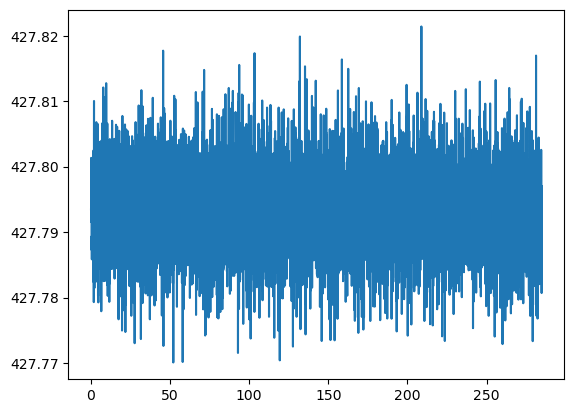

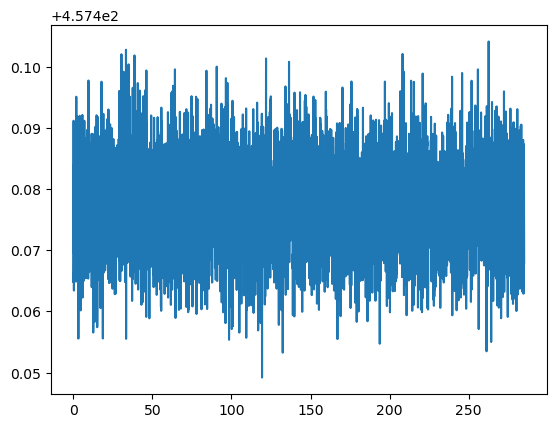

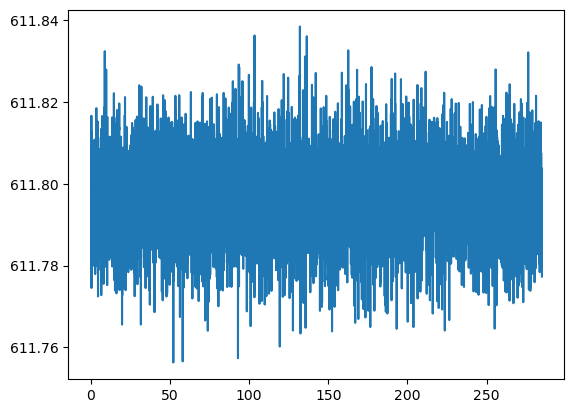

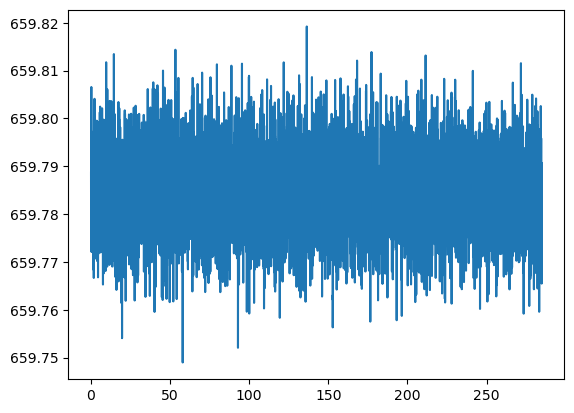

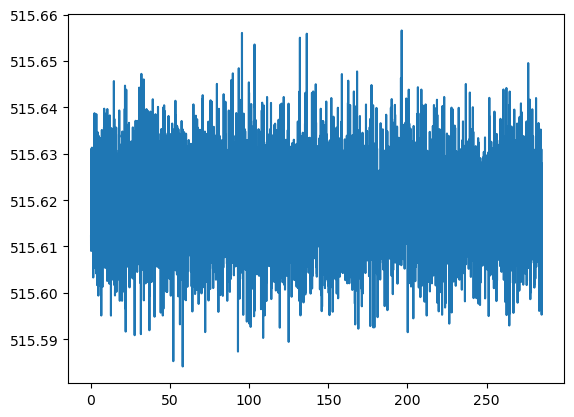

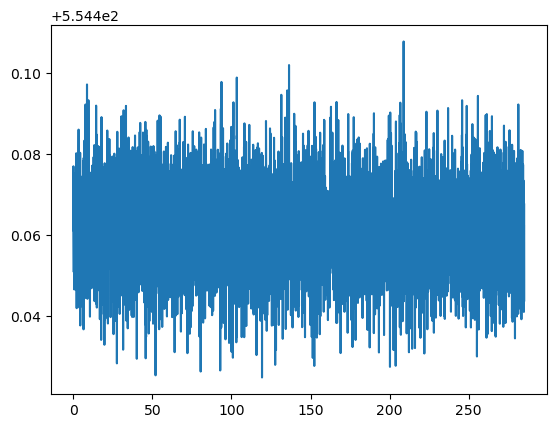

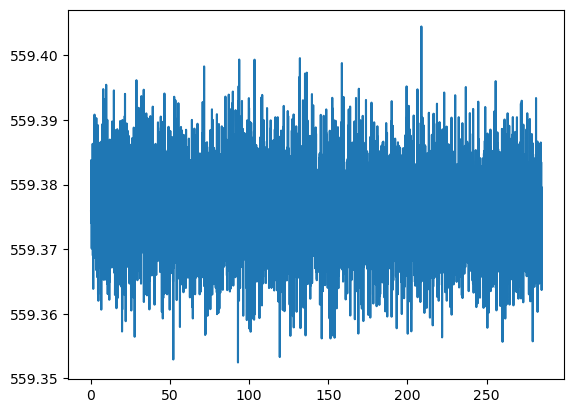

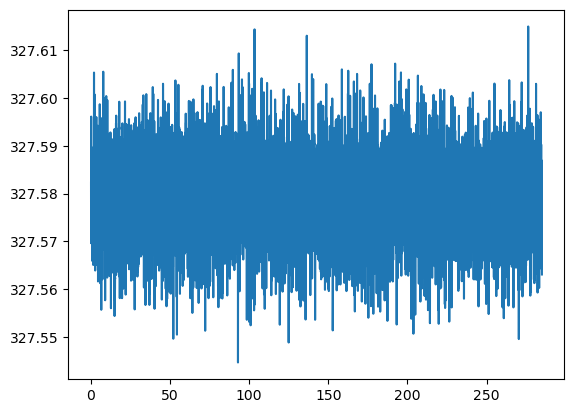

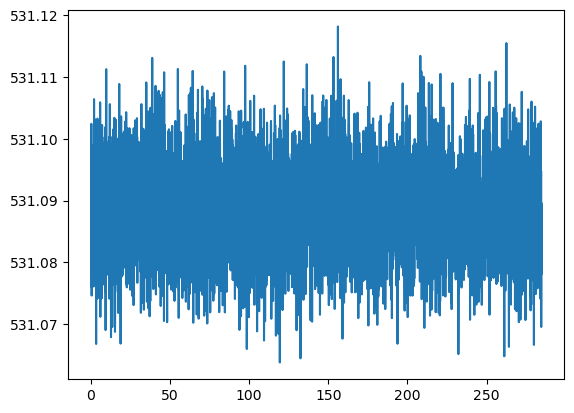

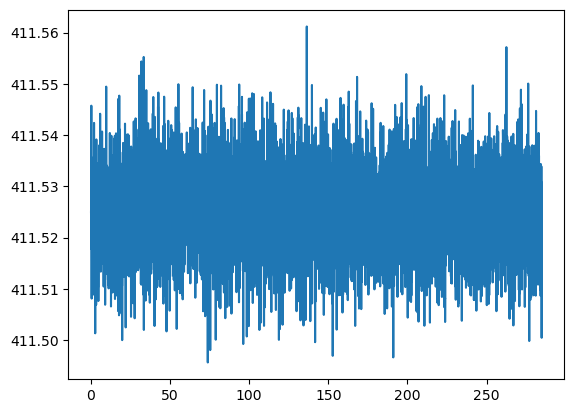

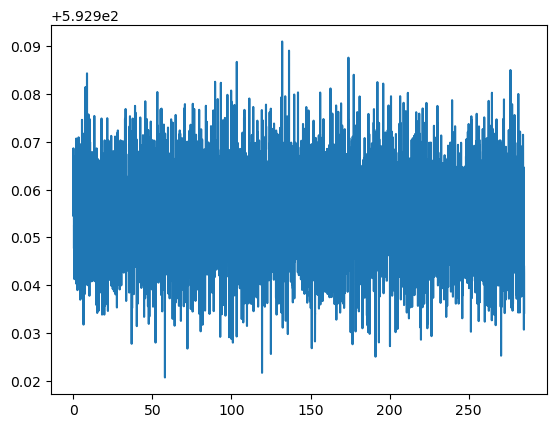

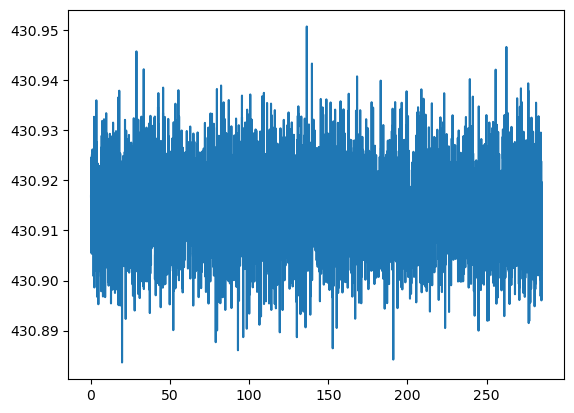

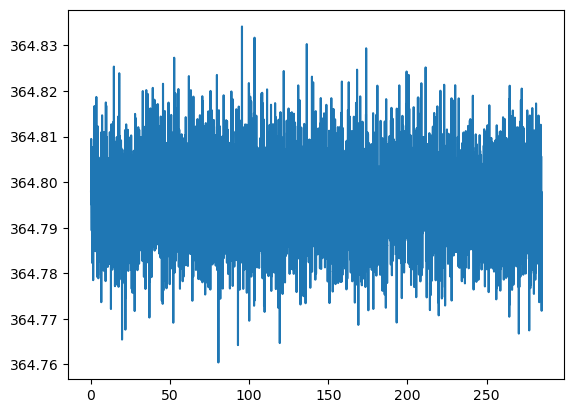

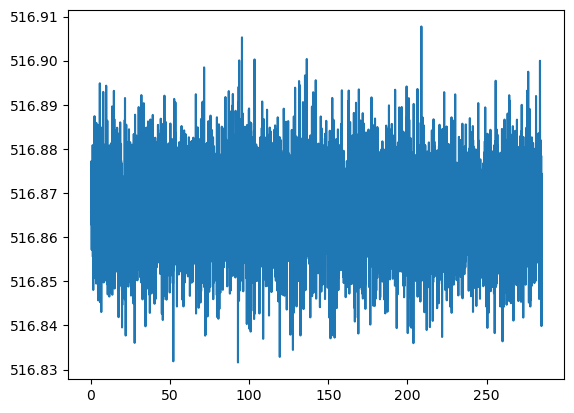

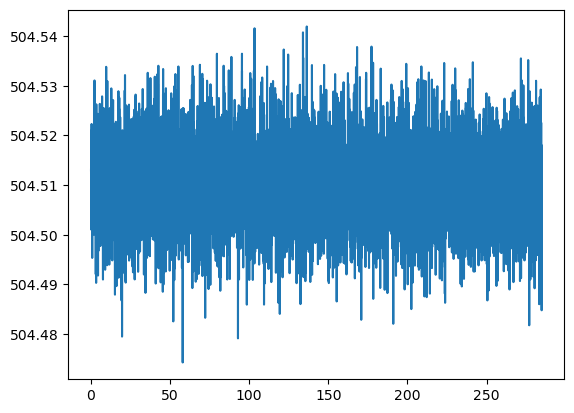

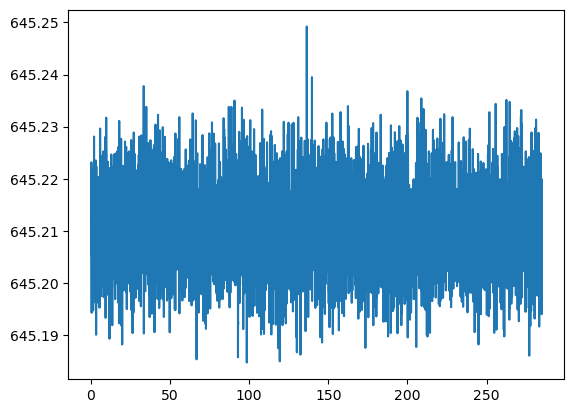

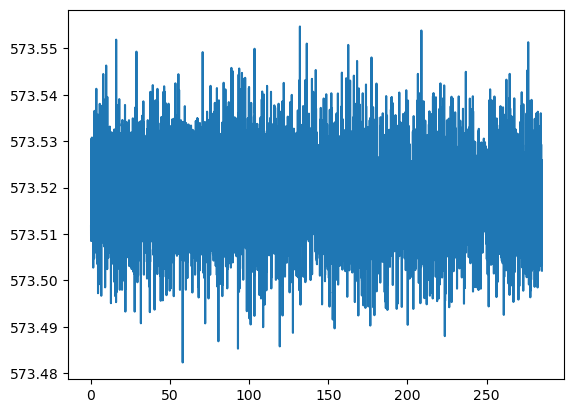

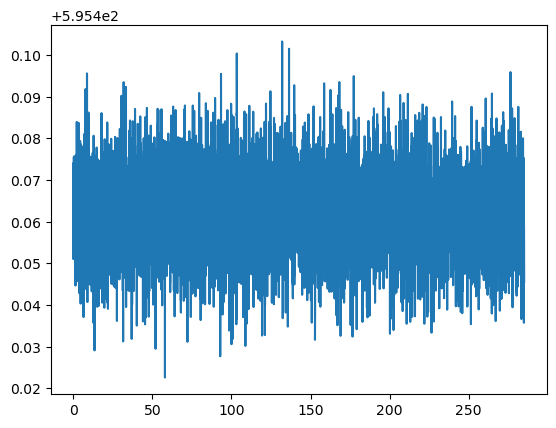

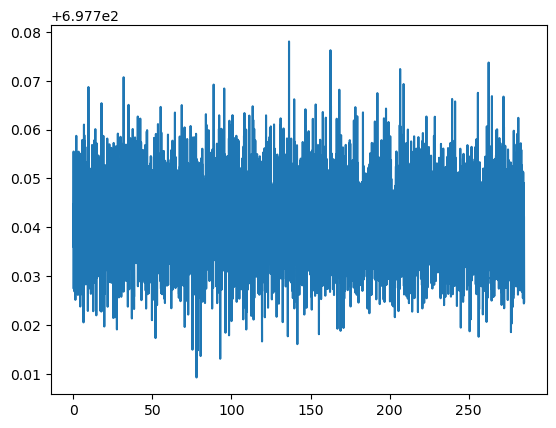

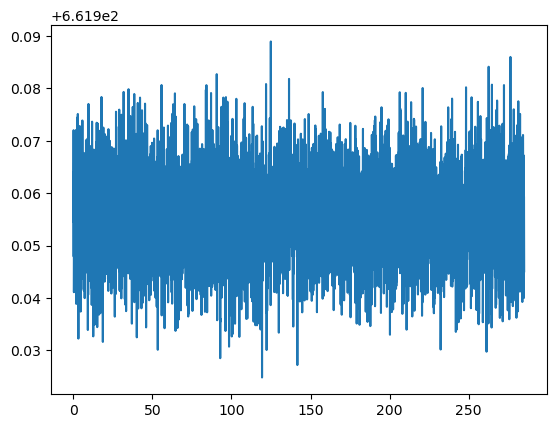

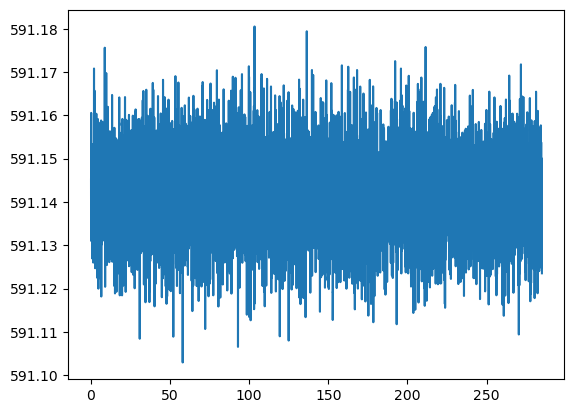

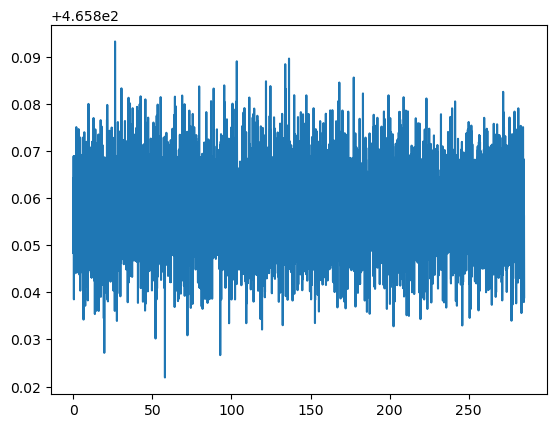

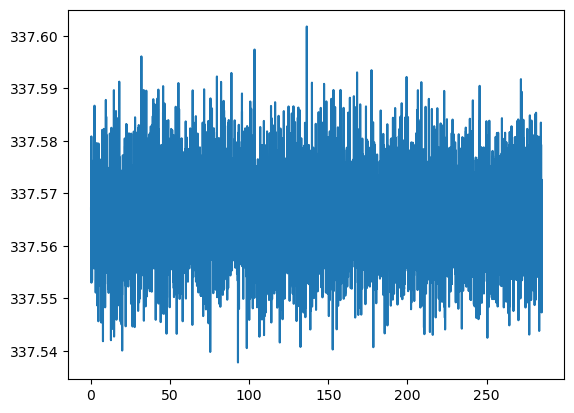

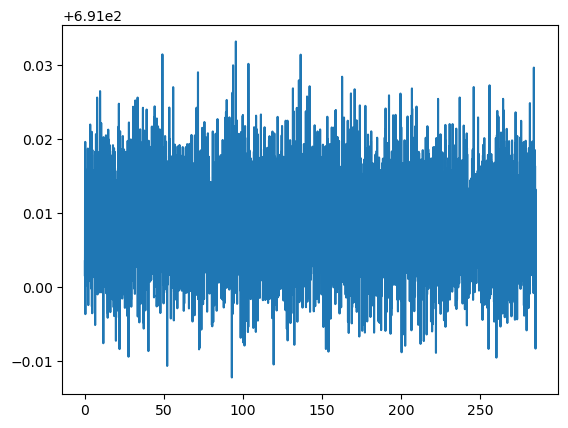

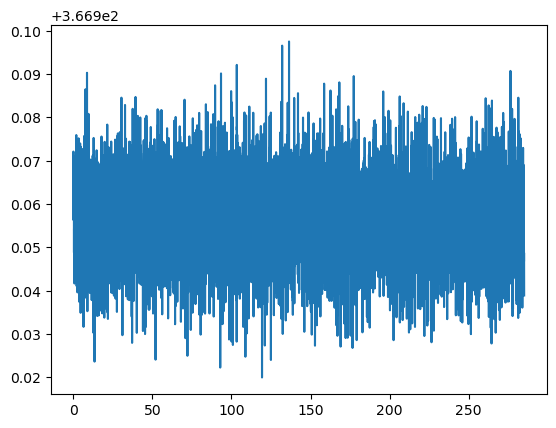

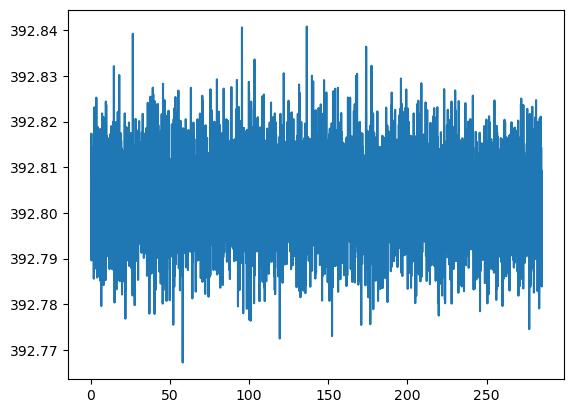

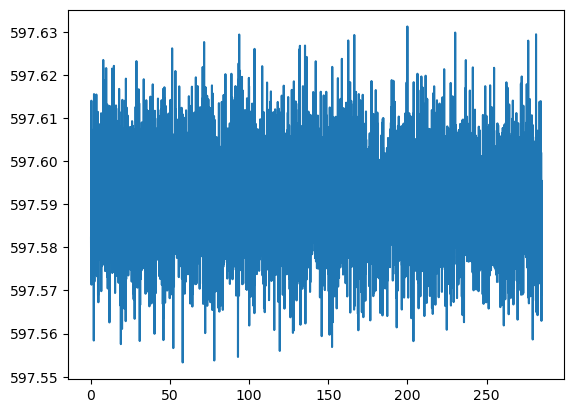

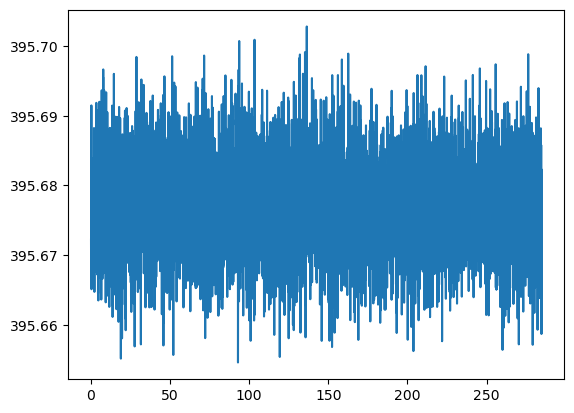

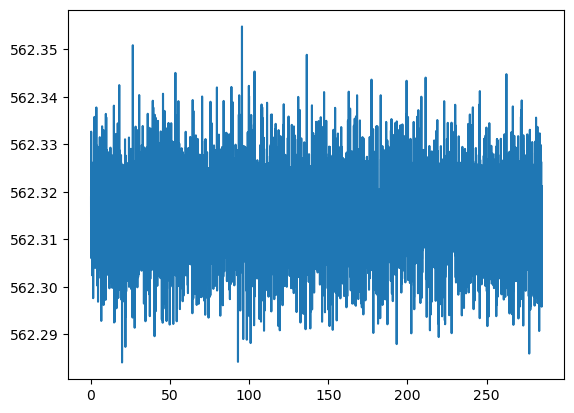

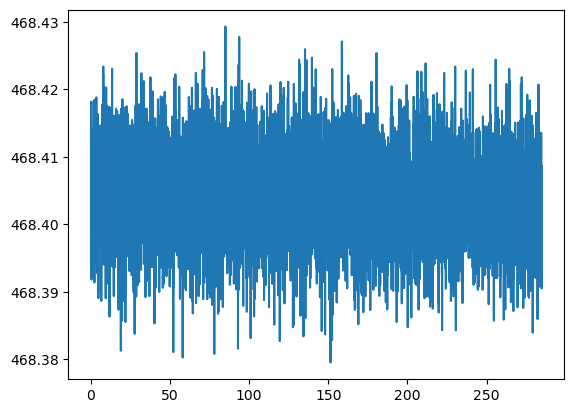

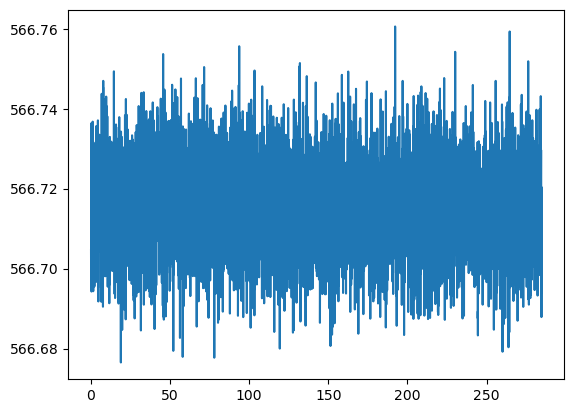

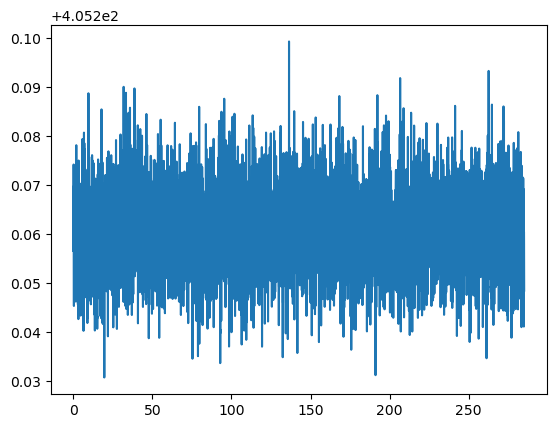

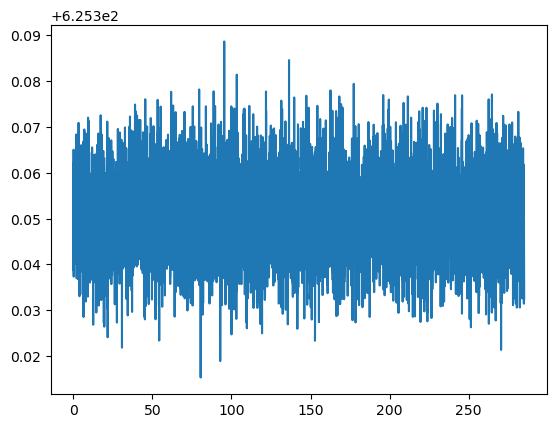

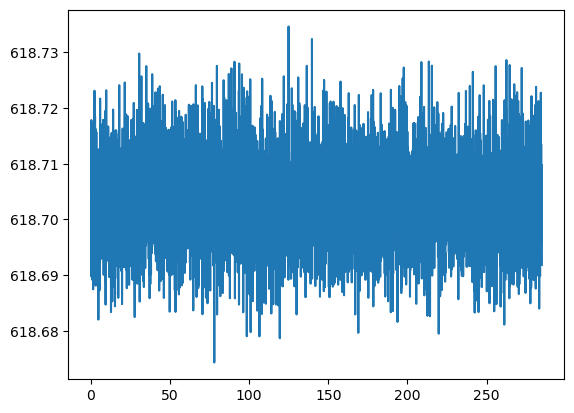

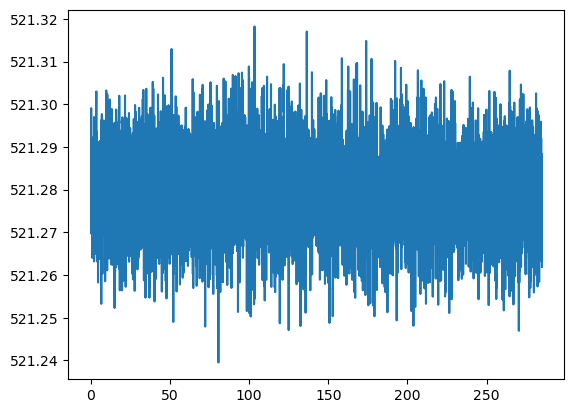

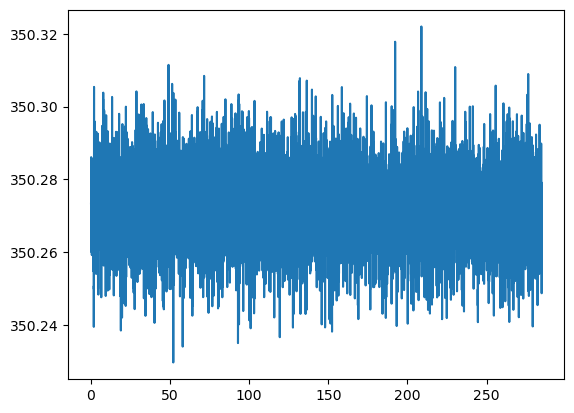

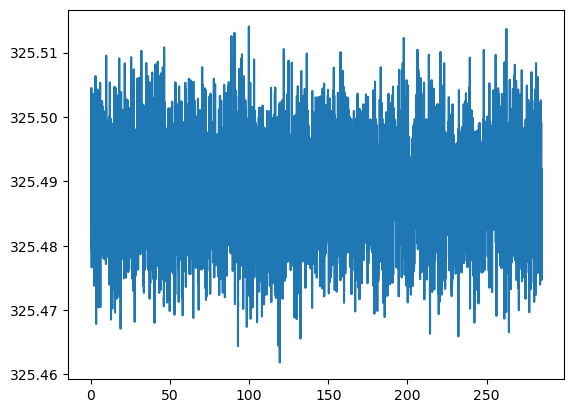

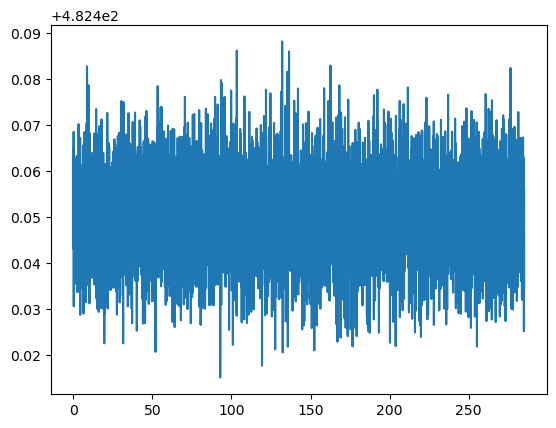

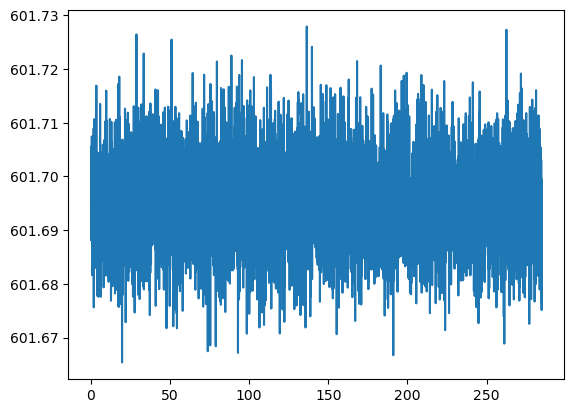

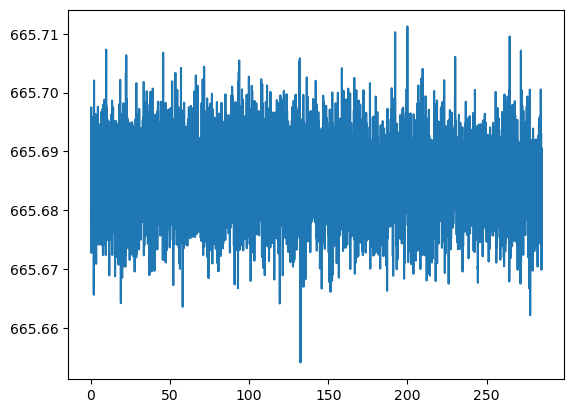

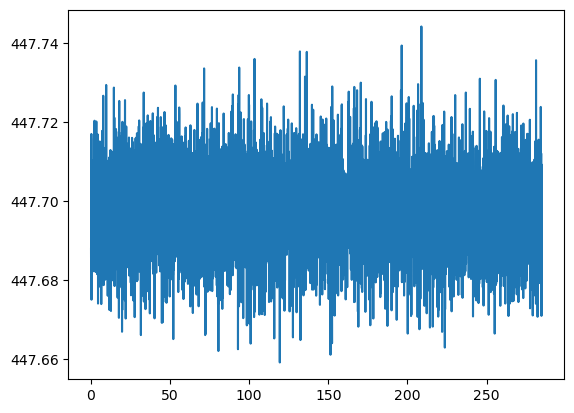

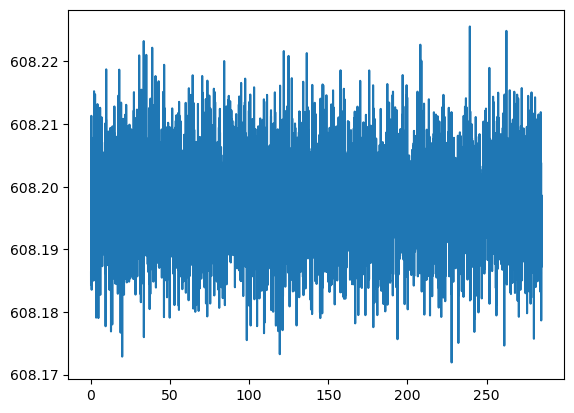

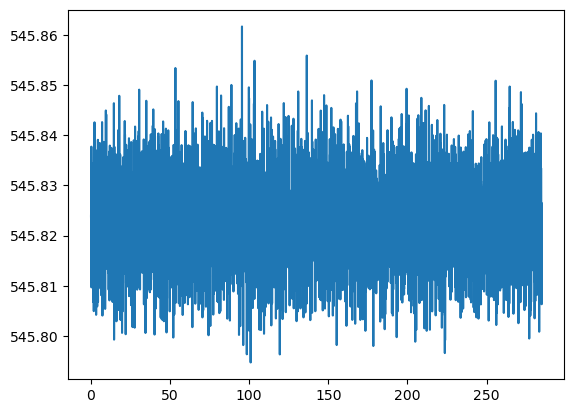

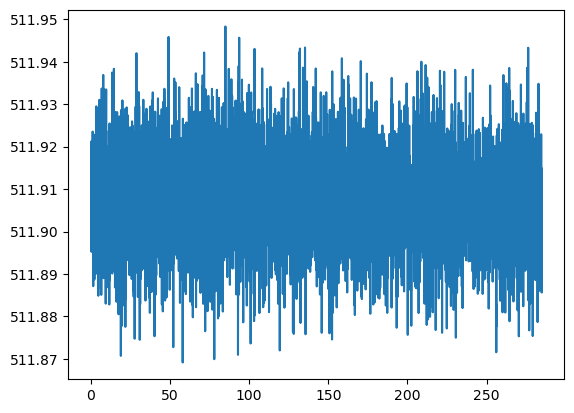

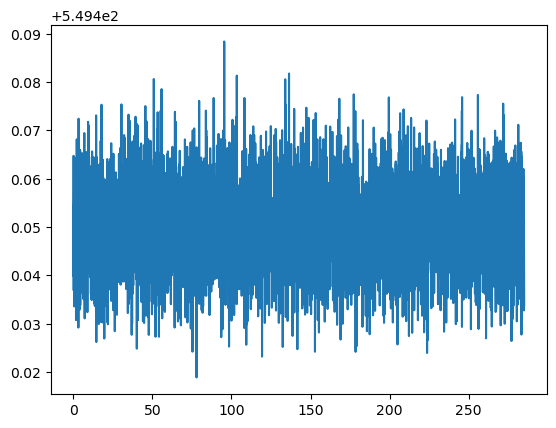

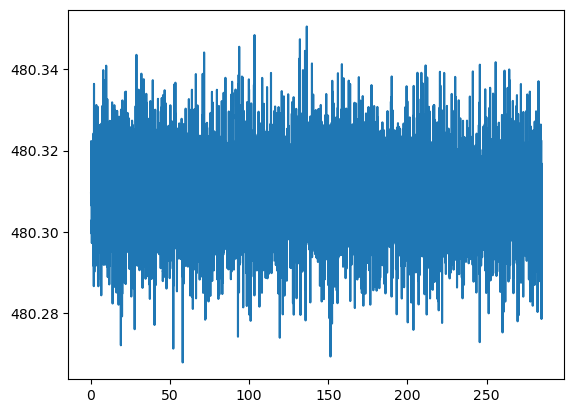

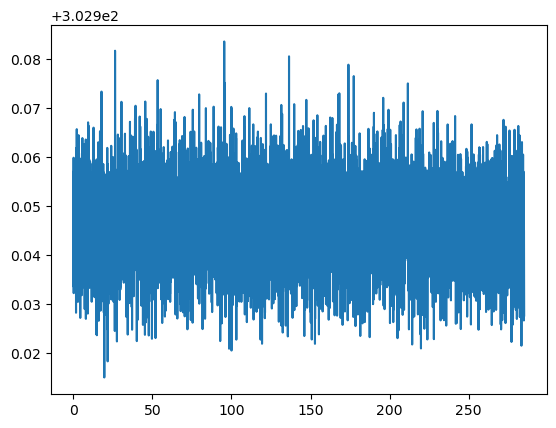

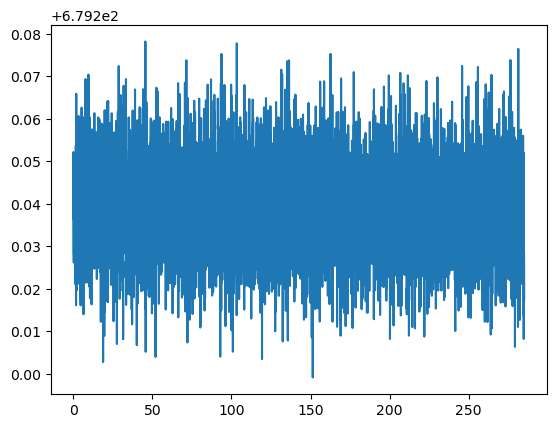

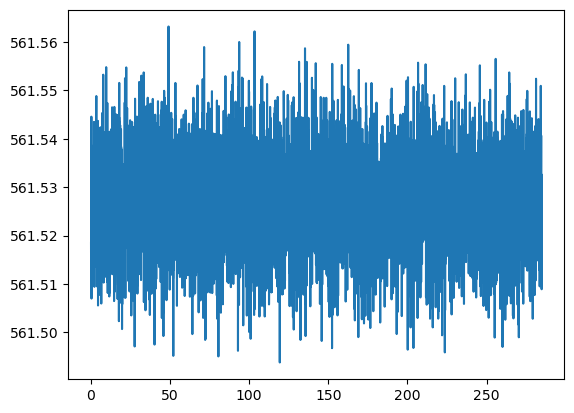

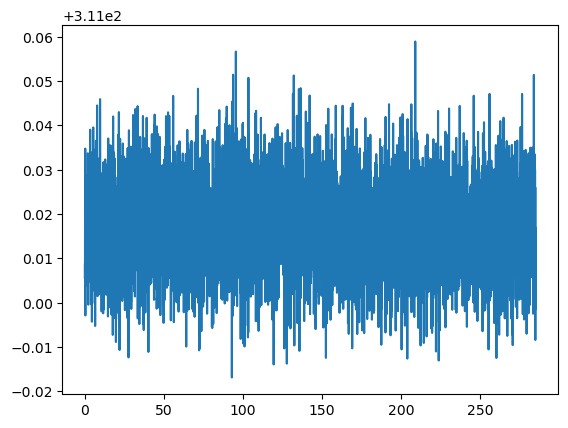

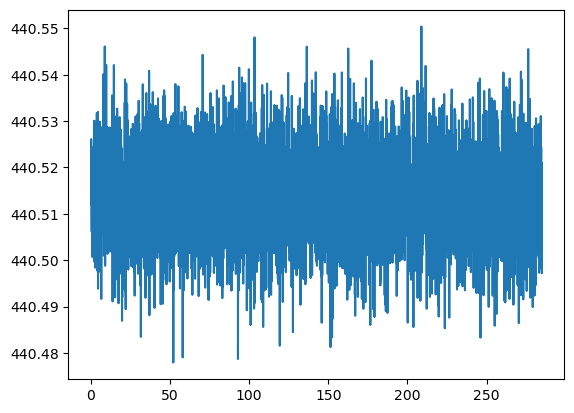

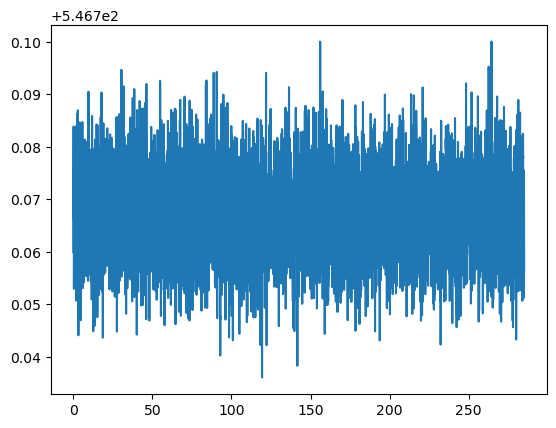

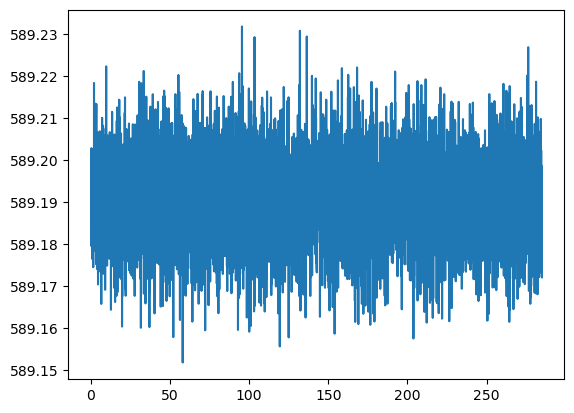

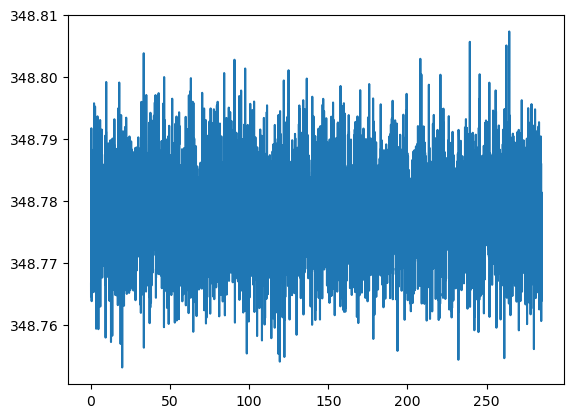

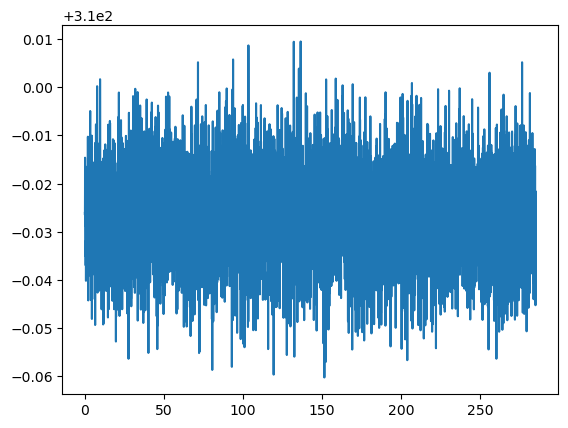

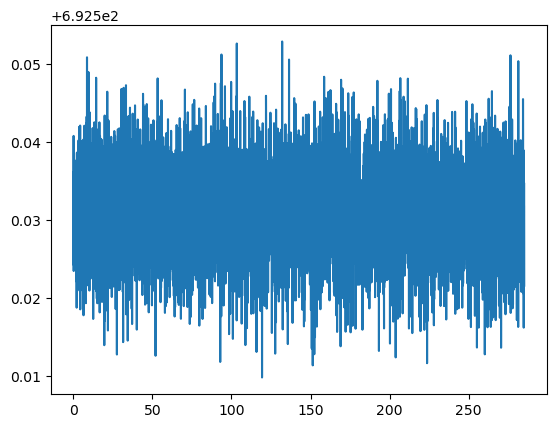

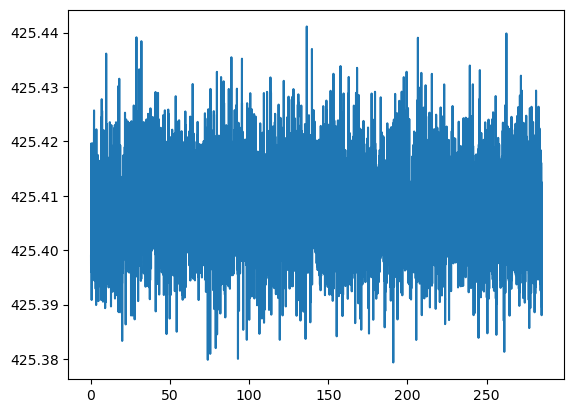

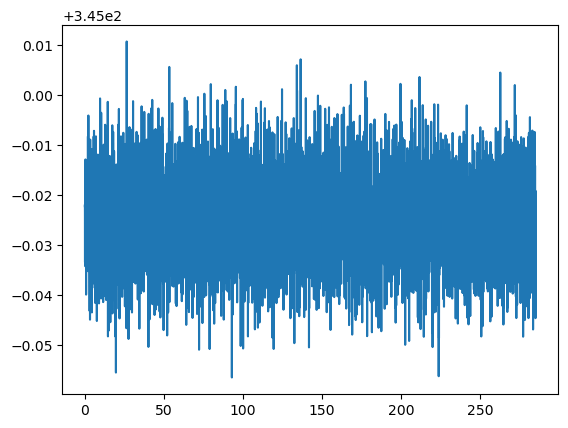

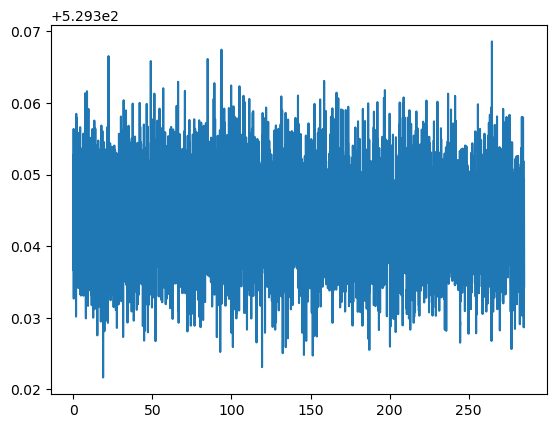

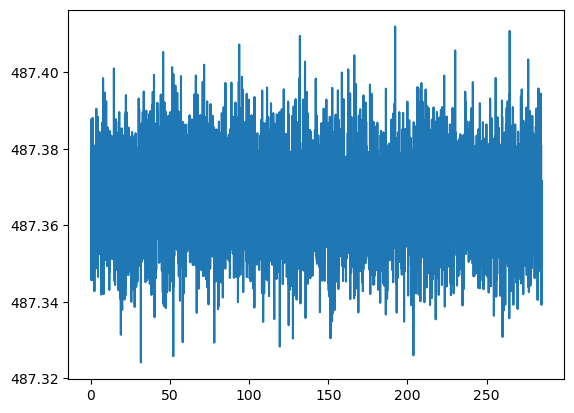

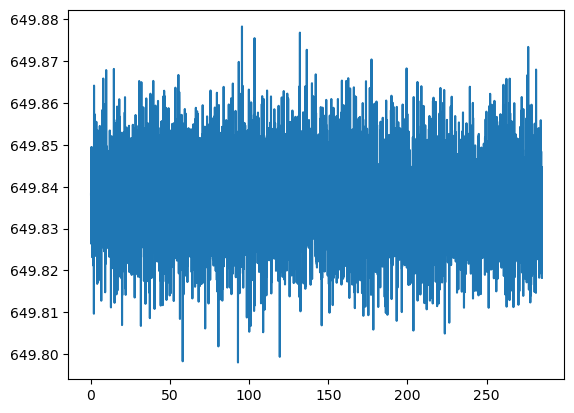

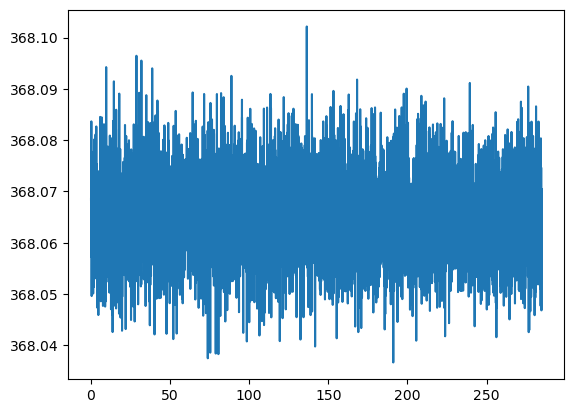

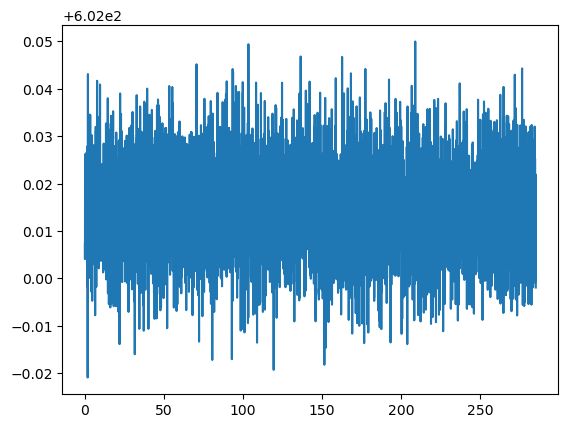

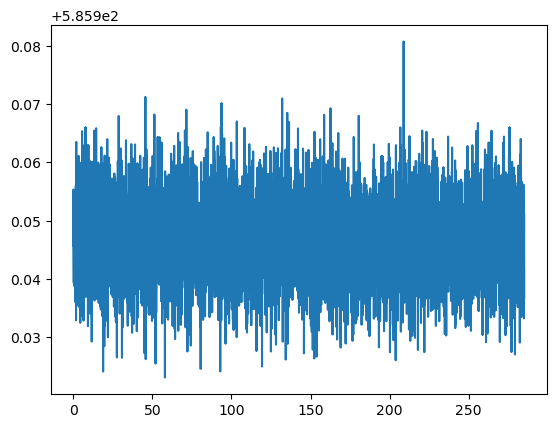

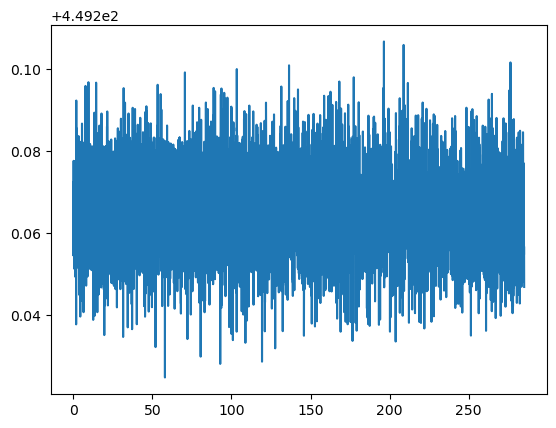

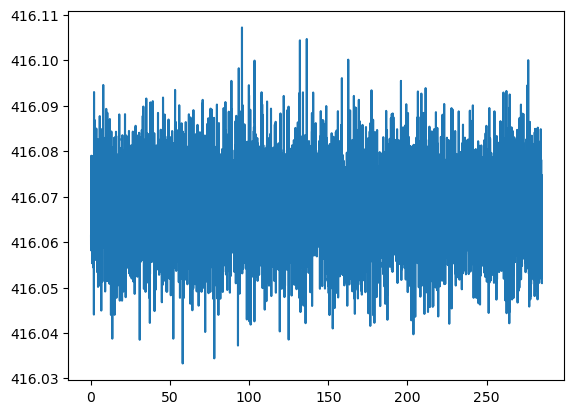

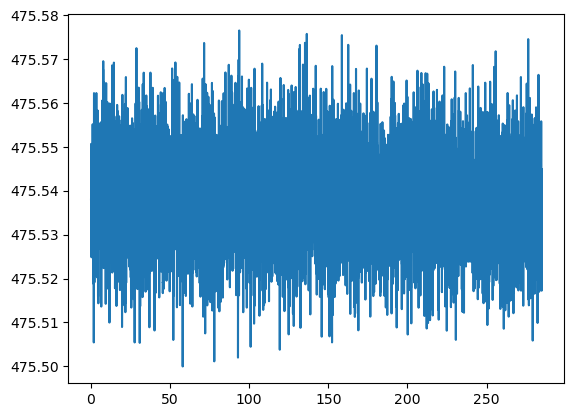

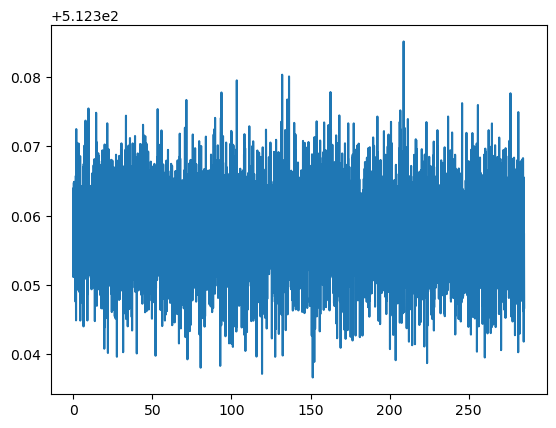

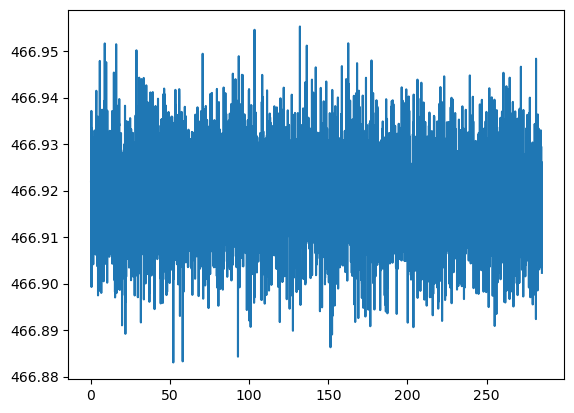

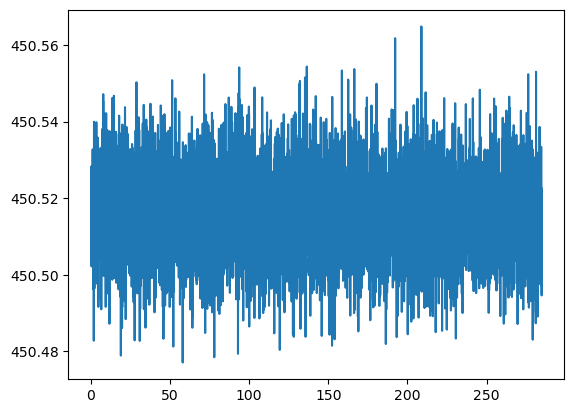

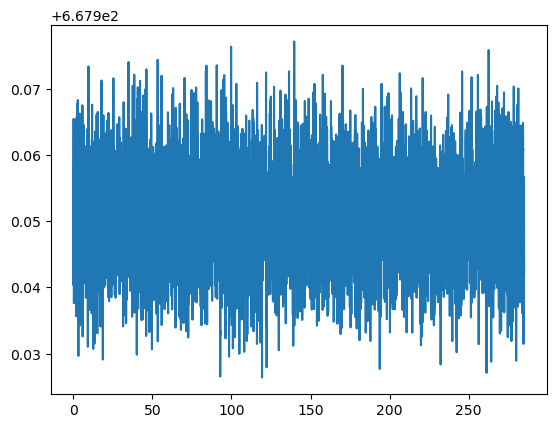

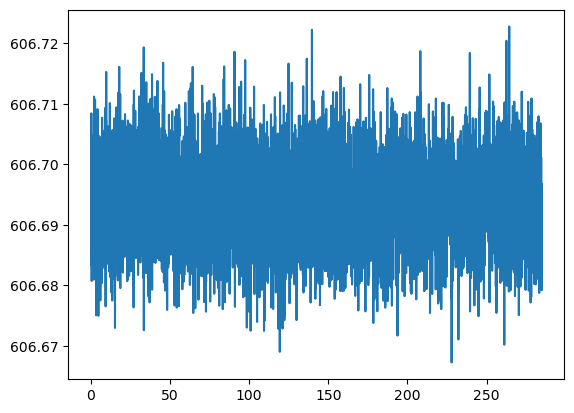

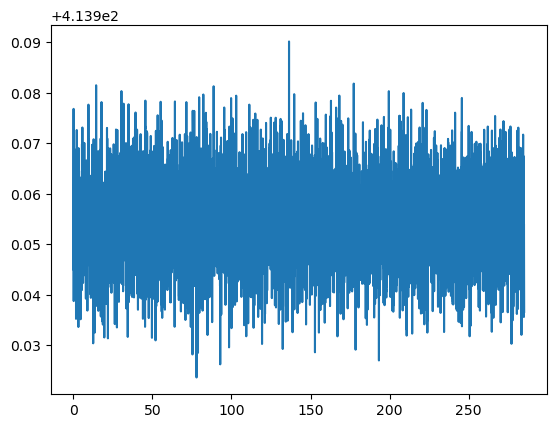

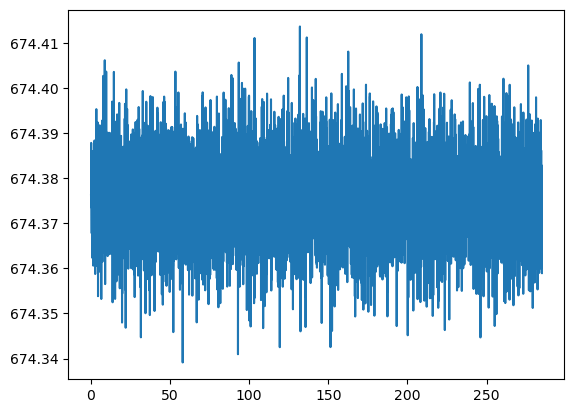

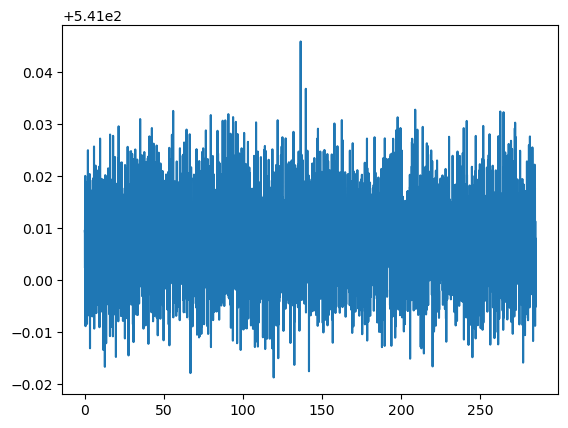

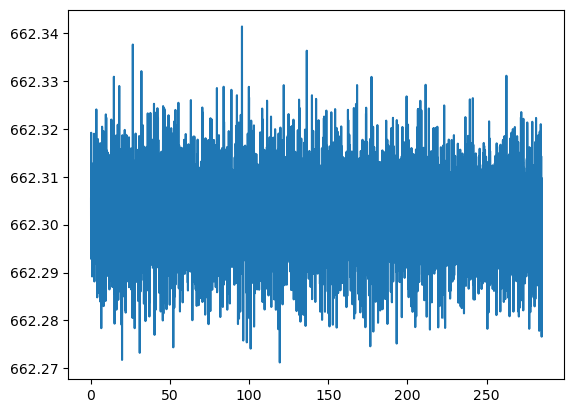

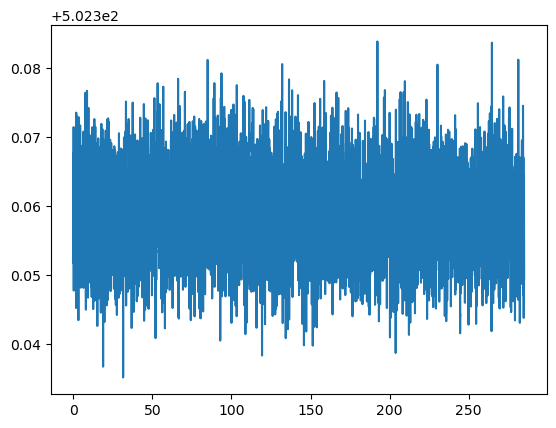

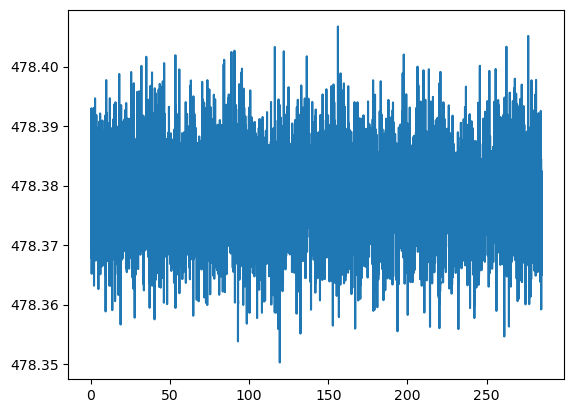

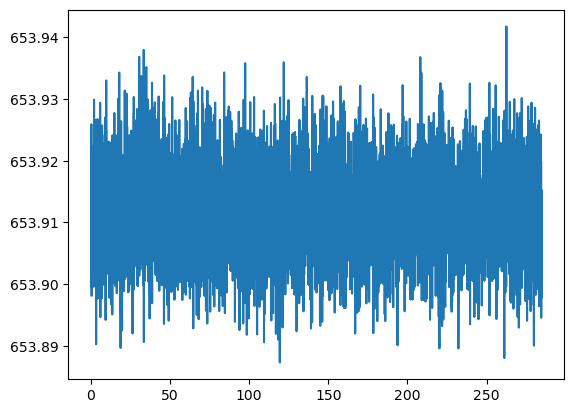

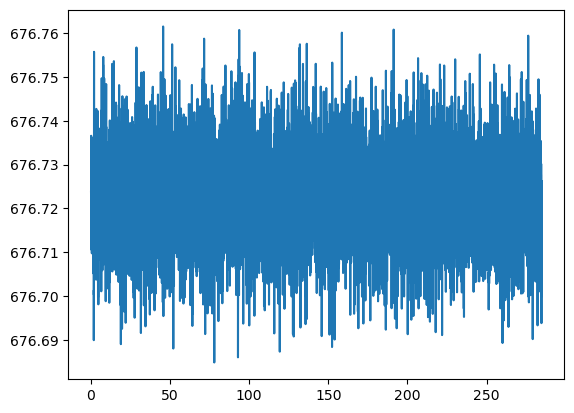

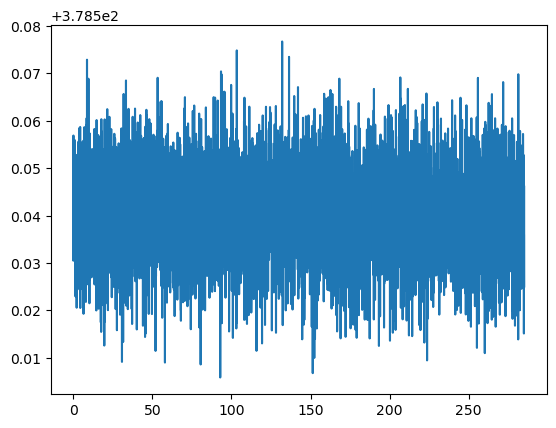

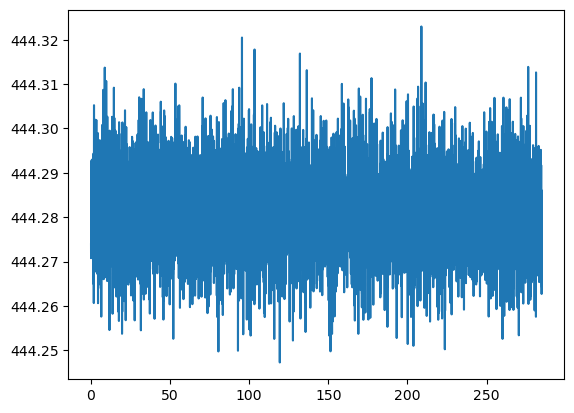

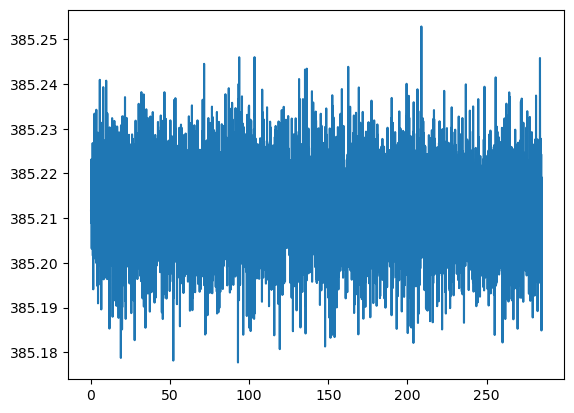

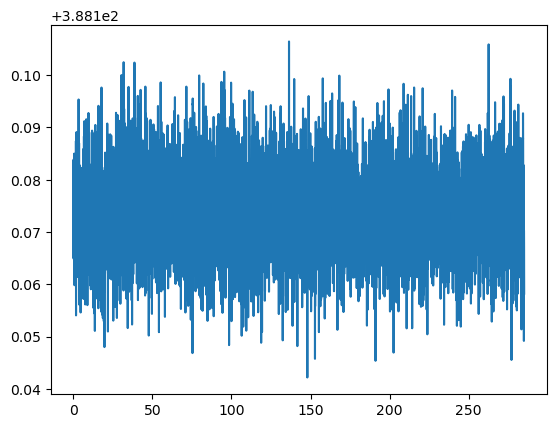

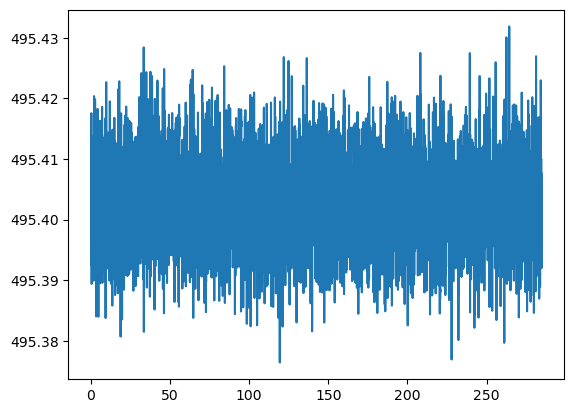

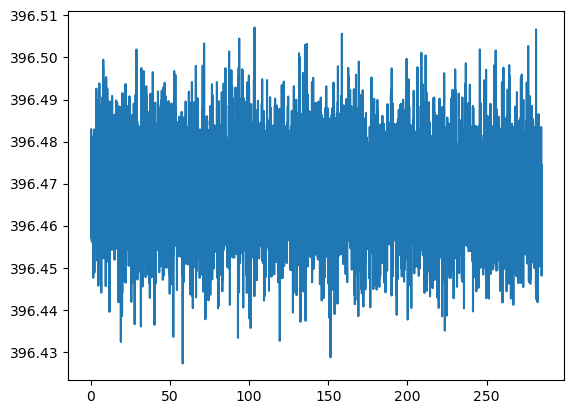

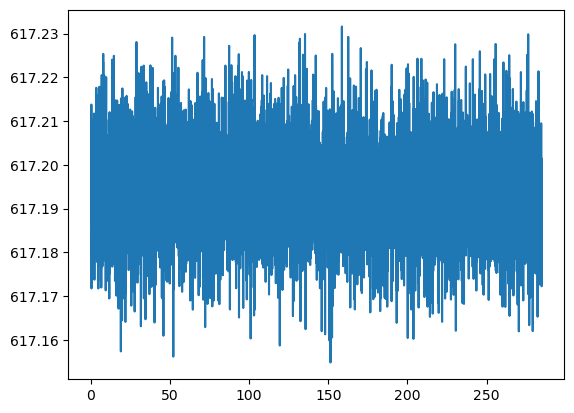

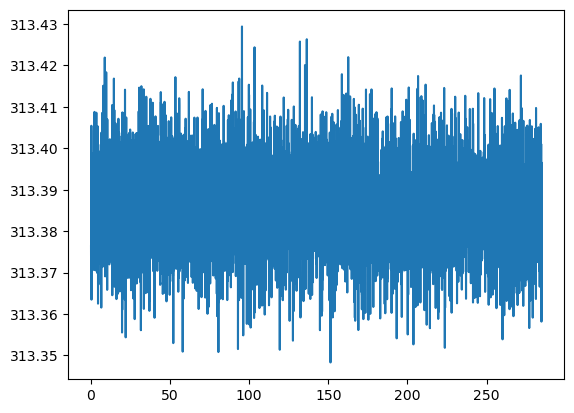

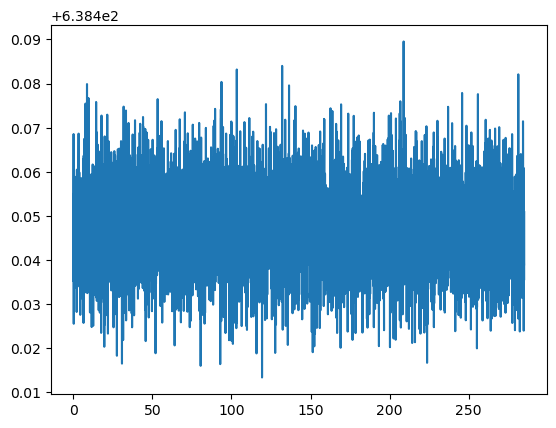

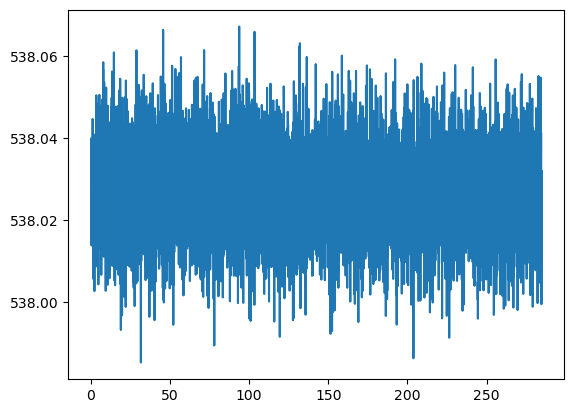

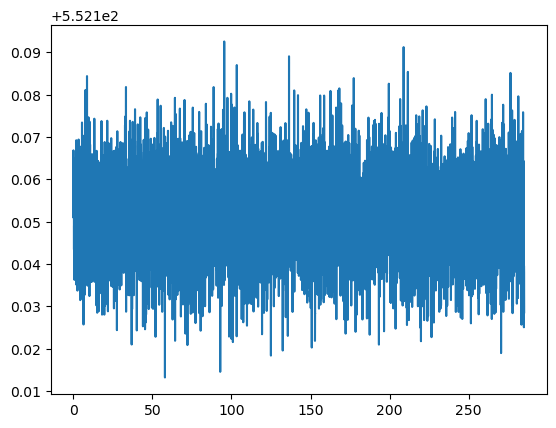

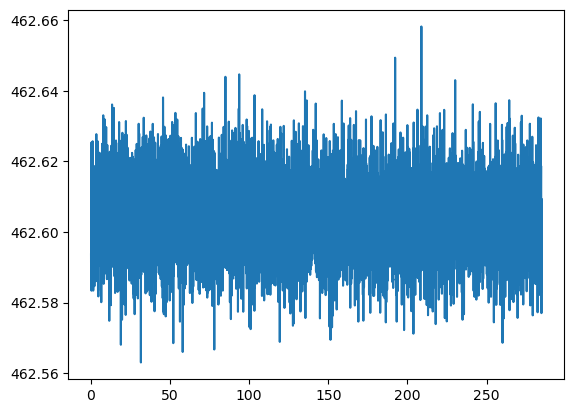

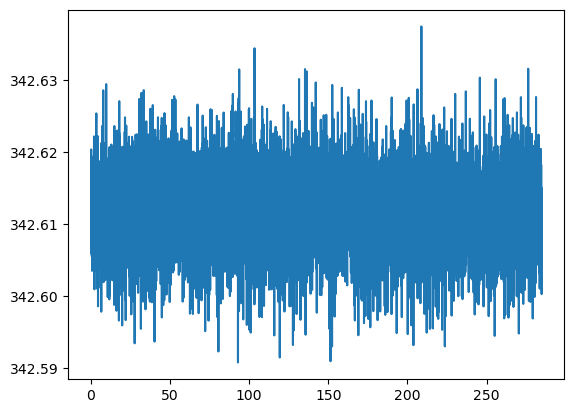

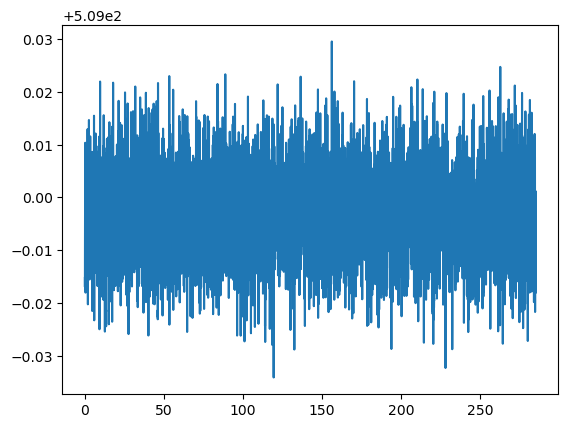

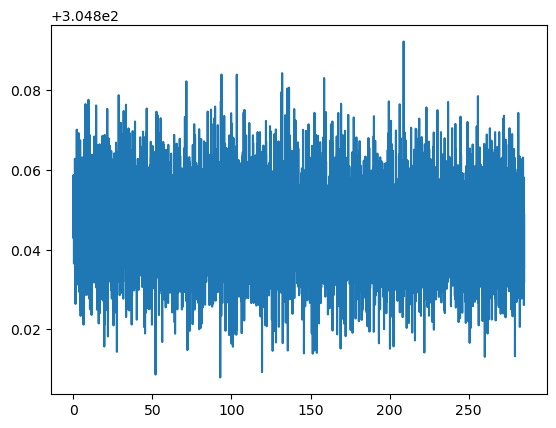

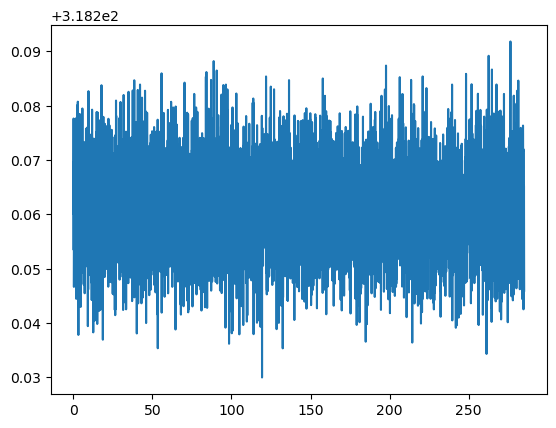

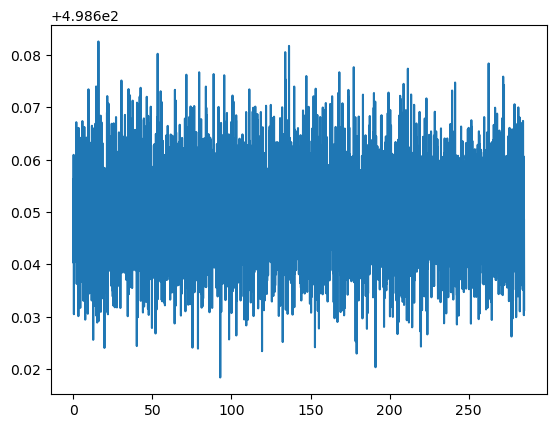

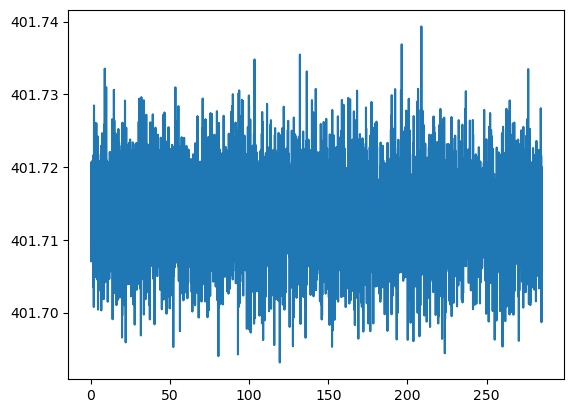

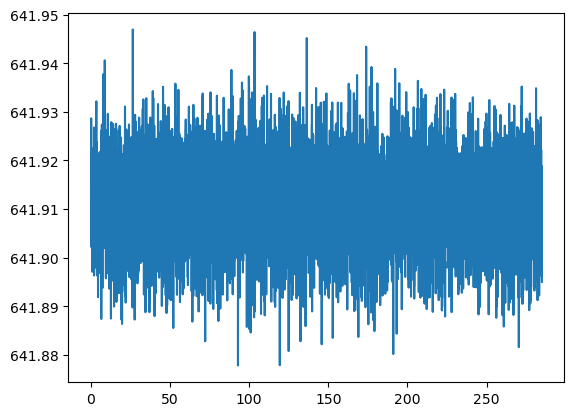

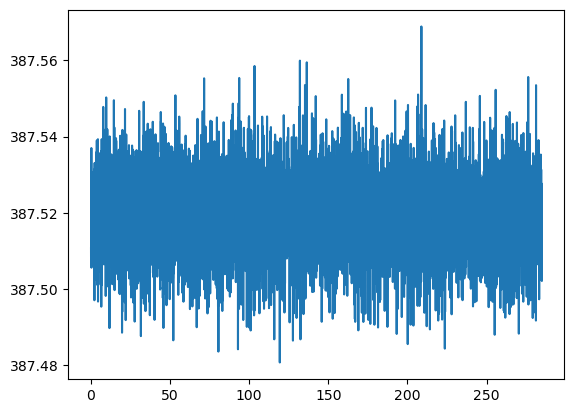

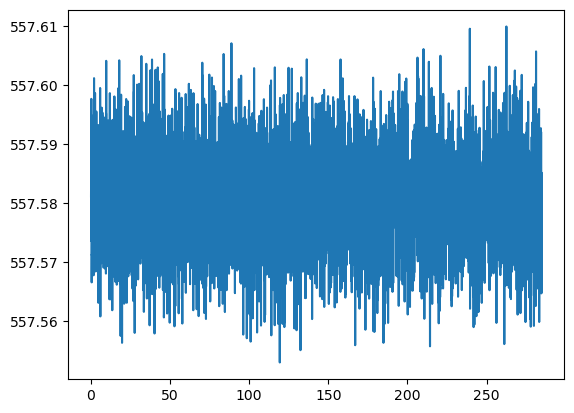

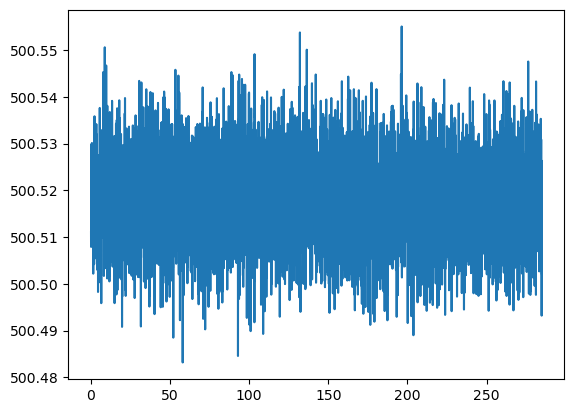

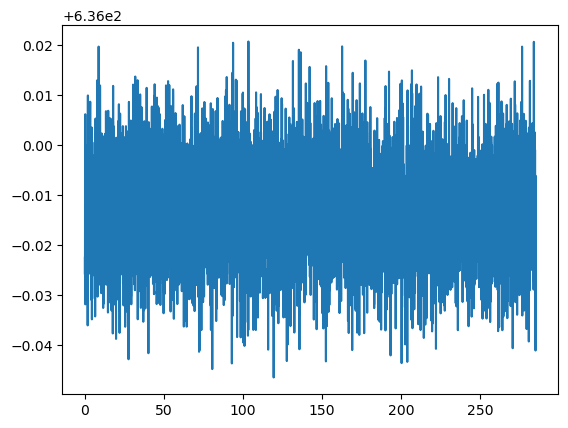

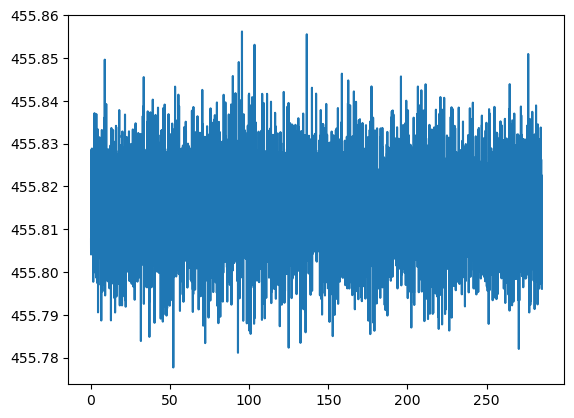

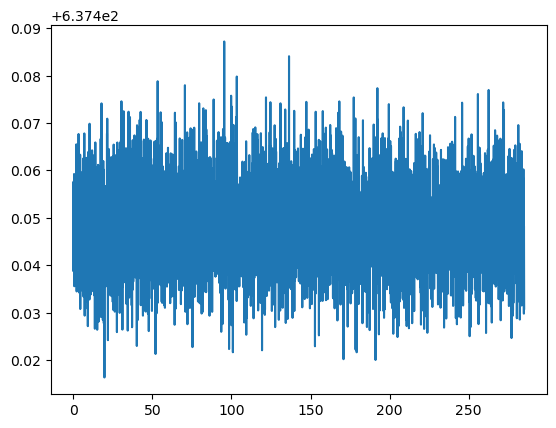

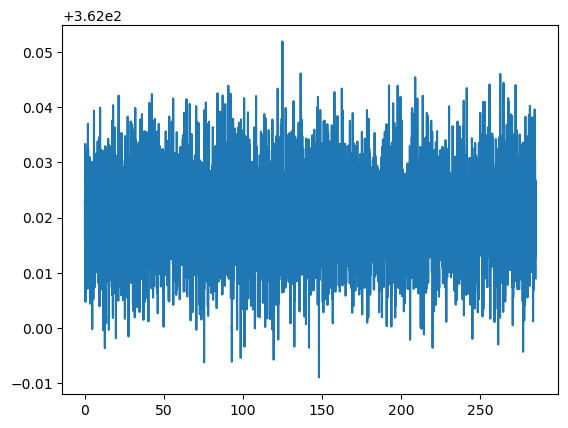

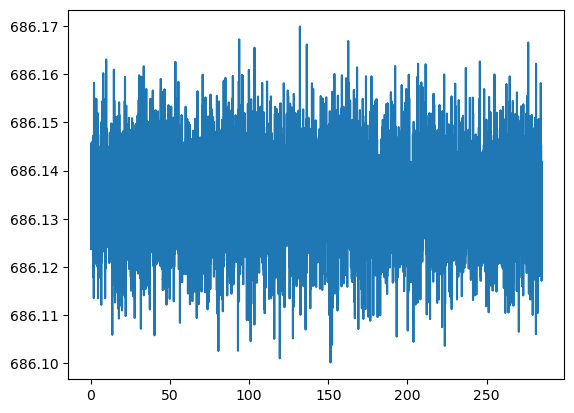

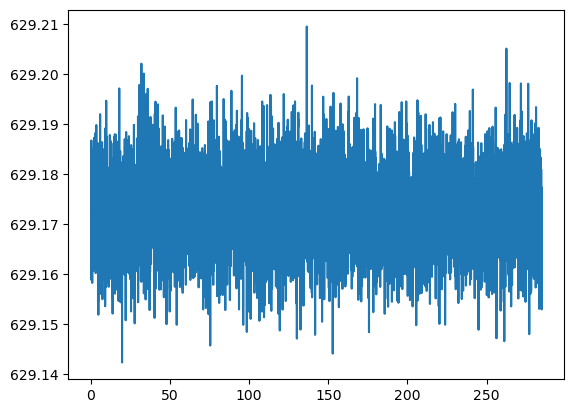

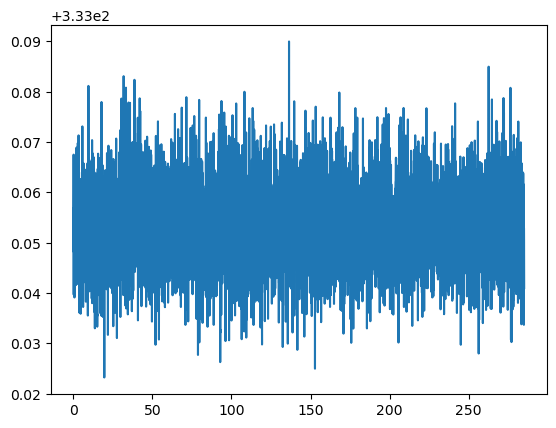

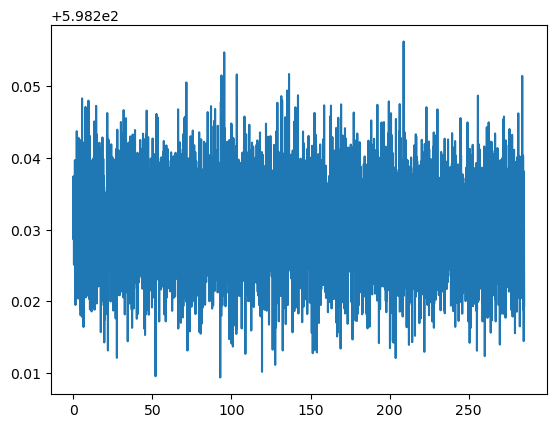

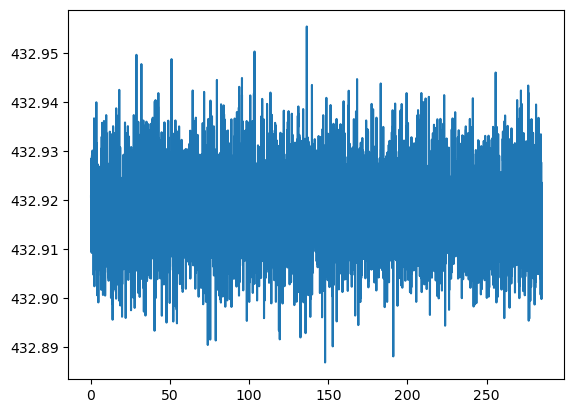

In [12]:
SimuFreq = 500  # Rate of simulation outputs, Hz
EndTime = 285  # End time of simulation (s). 285s for thin-wall sim
PadTime = 30   # Number of seconds to remove from beginning, must be greater than end time

FilePrefix = "FLP_"
for itr in range(0, number_samples):
    mean_power = mean_power_value[itr]
    Variance_laser_power = Variance_laser_power_value[itr]
    LaserPowerFreq = Frequency_value[itr] ## Figure this out

    ## Defining the step function
    #imp = signal.unit_impulse(SimuFreq)
    #b, a = signal.butter(4, 0.2)
    #response = -(signal.lfilter(b, a, imp)*Amplitude_of_step[itr])+1
    
    # stepfig, stepax = plt.subplots()
    #stepax.plot(response)

    ## Increasing size of array by interpolating 
    #old_indices_response = np.arange(0, len(response))
    #new_length_response = LaserPowerFreq
    #new_indices_response = np.linspace(0, len(response)-1, new_length_response)
    #spl_response = UnivariateSpline(old_indices_response,response,k=3,s=0)
    #data_n_response = spl_response(new_indices_response)
    with pm.Model() as model:
        mu = pm.Normal("mu", mu=mean_power, sigma=Variance_laser_power)

        step1 = pm.Metropolis(vars=[mu])
        idata = pm.sample(int(SimuFreq*(EndTime+PadTime)) + 1, chains=1, step=[step1], cores=1, return_inferencedata=True, random_seed=random_seed, progressbar = False)
    fig, ax = plt.subplots()

    chain_input = idata.posterior.mu.transpose().squeeze()

    idata_n_response = np.ones([SimuFreq, 1])   # Base signal, to which to apply the variation
    RawSignal = np.array(idata.posterior.mu*idata_n_response)[0,:]

    # Filtering output signal to frequency
    b, a = signal.butter(2, LaserPowerFreq, fs=SimuFreq)
    FilteredSignal = signal.filtfilt(b, a, RawSignal)

    # Fixes Weird initial peak issue by setting initial point to the value of the last point
    FilteredSignal = FilteredSignal[int(PadTime*SimuFreq):]

    # Time Step
    TimeVector = np.linspace(0, EndTime, int(SimuFreq*EndTime + 1))
    plt.plot(TimeVector, FilteredSignal)

    # Export
    out_df = pd.DataFrame({'laser_power': FilteredSignal, 'time_elapsed': TimeVector})
    out_df.to_csv(FilePrefix + str(itr + 1) + ".csv", index=False)


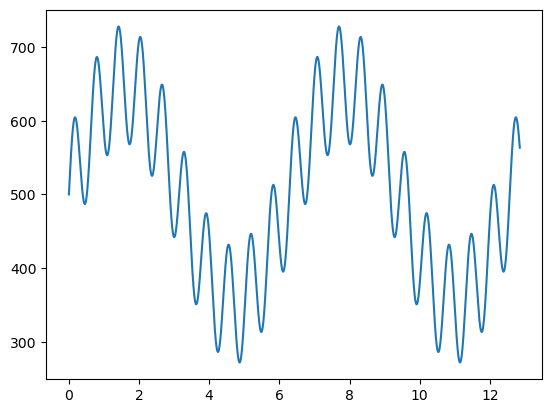

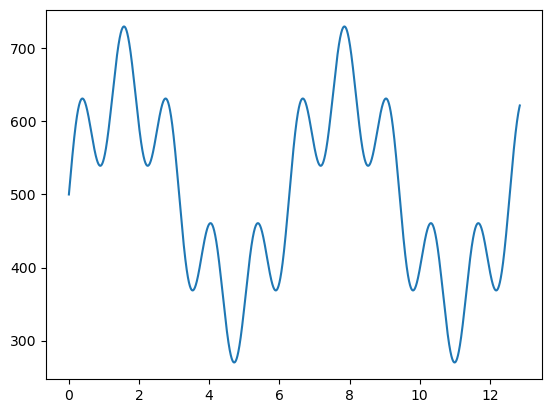

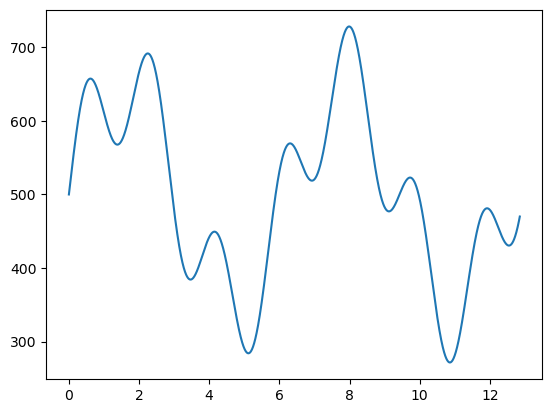

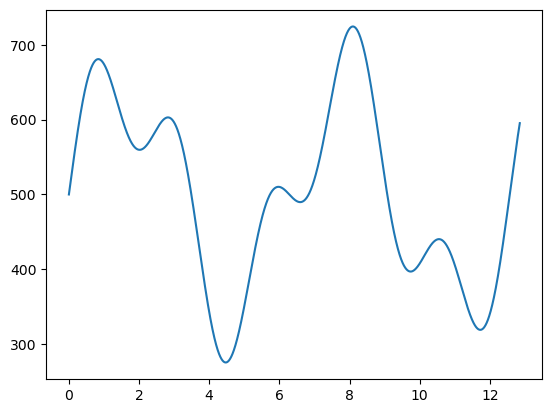

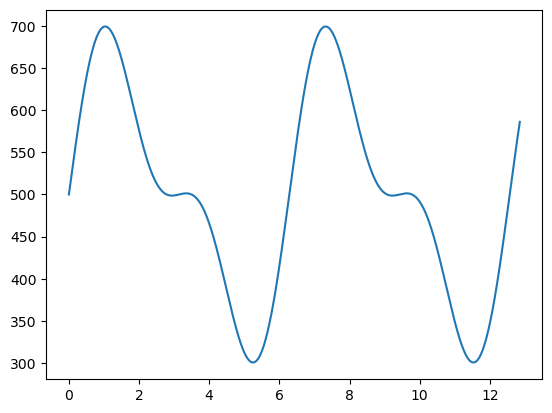

In [12]:
num_datapoints = 6428 # Number of data points to generate
num_profs = 5 # Number of profiles to generate
dt = 0.002

t_vec = np.arange(0, dt*(num_datapoints), dt, dtype=np.float64)
for itr in range(0, num_profs):
    laser_power = 150.*np.sin(t_vec) + 500. + 4*20.*np.sin(10*t_vec/(itr+1))
    fig, ax = plt.subplots()
    ax.plot(t_vec, laser_power)

    out_df = pd.DataFrame({'laser_power': laser_power, 'time_elapsed': t_vec})
    out_df.to_csv("LP_" + str(itr + 1) + ".csv", index=False)
    #print(out_df)